In [1]:
import pandas as pd

# Load the dataset
file_path = 'C:/Users/sachi/Desktop/MSc Data Science/ML Coursework/TrainDataset2024 (1).csv'
data = pd.read_csv(file_path)

# Basic dataset inspection
data_info = {
    "Shape": data.shape,
    "Columns": data.columns.tolist(),
    "Missing Values": (data == 999).sum().to_dict(),  # Identify '999' as missing values
    "First Rows": data.head(),
    "Summary": data.describe(include='all')
}

data_info


{'Shape': (400, 121),
 'Columns': ['ID',
  'pCR (outcome)',
  'RelapseFreeSurvival (outcome)',
  'Age',
  'ER',
  'PgR',
  'HER2',
  'TrippleNegative',
  'ChemoGrade',
  'Proliferation',
  'HistologyType',
  'LNStatus',
  'TumourStage',
  'Gene',
  'original_shape_Elongation',
  'original_shape_Flatness',
  'original_shape_LeastAxisLength',
  'original_shape_MajorAxisLength',
  'original_shape_Maximum2DDiameterColumn',
  'original_shape_Maximum2DDiameterRow',
  'original_shape_Maximum2DDiameterSlice',
  'original_shape_Maximum3DDiameter',
  'original_shape_MeshVolume',
  'original_shape_MinorAxisLength',
  'original_shape_Sphericity',
  'original_shape_SurfaceArea',
  'original_shape_SurfaceVolumeRatio',
  'original_shape_VoxelVolume',
  'original_firstorder_10Percentile',
  'original_firstorder_90Percentile',
  'original_firstorder_Energy',
  'original_firstorder_Entropy',
  'original_firstorder_InterquartileRange',
  'original_firstorder_Kurtosis',
  'original_firstorder_Maximum',
  

In [2]:
import numpy as np
from sklearn.impute import KNNImputer

# Replace '999' with NaN for easier processing
data = data.replace(999, np.nan)

# Calculate missing value counts
missing_values = data.isnull().sum()

# Filter features with missing values
features_with_missing = missing_values[missing_values > 0].sort_values(ascending=False)

# Display features with missing values
print("Features with Missing Values (Counts):")
print(features_with_missing)

# Define feature groups
clinical_features = [
    "Age", "ER", "PgR", "HER2", "TrippleNegative", "ChemoGrade",
    "Proliferation", "HistologyType", "LNStatus", "TumourStage", "Gene"
]
radiomics_features = [col for col in data.columns if col.startswith("original")]
discrete_clinical_features = ["ER", "PgR", "HER2", "TrippleNegative", "ChemoGrade", "HistologyType", "LNStatus", "Gene"]

# Perform KNN imputation
imputer = KNNImputer(n_neighbors=5)
data_imputed = data.copy()
data_imputed[clinical_features + radiomics_features] = imputer.fit_transform(data[clinical_features + radiomics_features])

# Define valid categories for discrete features
valid_values = {
    "ER": [0, 1],
    "PgR": [0, 1],
    "HER2": [0, 1],
    "TrippleNegative": [0, 1],
    "ChemoGrade": [1, 2, 3],
    "Proliferation": [1,2,3],
    "HistologyType": [1, 2],
    "LNStatus": [0, 1],
    "TumourStage": [1,2,3,4],
    "Gene": [0, 1]
}

# Function to re-impute discrete features by rounding to the nearest valid category
def re_impute_discrete_features(df, features, valid_values):
    """
    Re-impute discrete features by mapping imputed values back to the closest valid category.
    
    Args:
        df: DataFrame containing the features to process.
        features: List of feature names to process.
        valid_values: Dictionary of valid values for each feature.
        
    Returns:
        DataFrame with re-imputed discrete features.
    """
    for feature in features:
        df[feature] = df[feature].apply(lambda x: min(valid_values[feature], key=lambda y: abs(y - x)))
    return df

# Apply stricter constraints for discrete clinical features
data_imputed_corrected = re_impute_discrete_features(data_imputed.copy(), discrete_clinical_features, valid_values)

# Verify the corrected values for discrete features
for feature in discrete_clinical_features:
    print(f"{feature} unique values after correction: {data_imputed_corrected[feature].unique()}")



Features with Missing Values (Counts):
Gene               88
pCR (outcome)       5
ChemoGrade          3
HistologyType       3
Proliferation       2
PgR                 1
HER2                1
TrippleNegative     1
LNStatus            1
dtype: int64
ER unique values after correction: [0 1]
PgR unique values after correction: [0 1]
HER2 unique values after correction: [0 1]
TrippleNegative unique values after correction: [1 0]
ChemoGrade unique values after correction: [3 2 1]
HistologyType unique values after correction: [1 2]
LNStatus unique values after correction: [1 0]
Gene unique values after correction: [1 0]


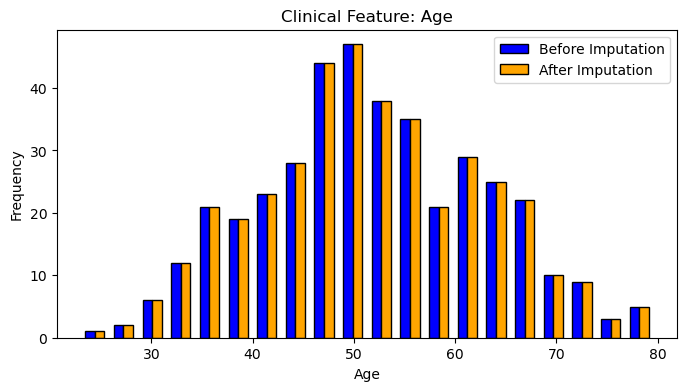

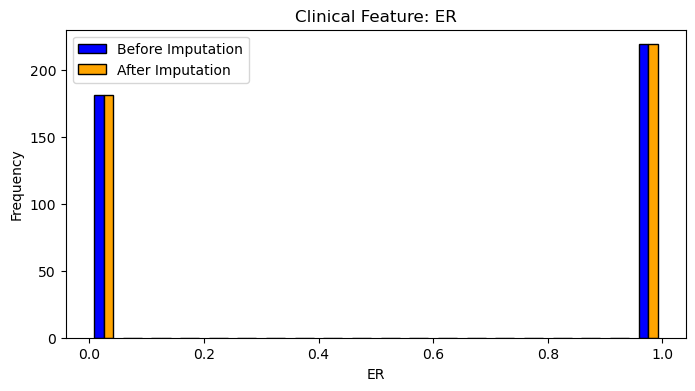

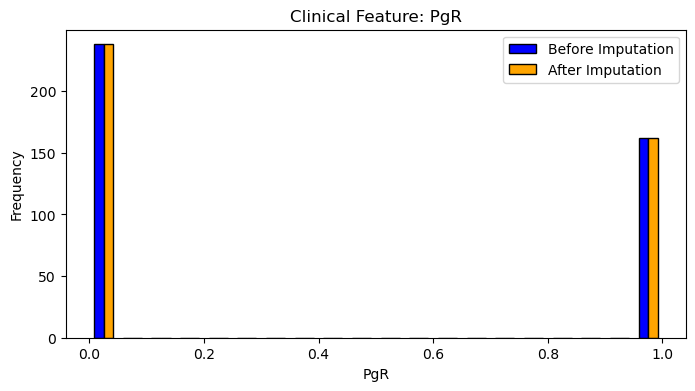

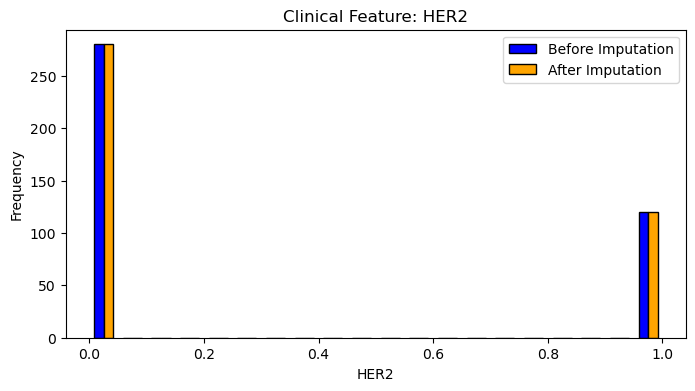

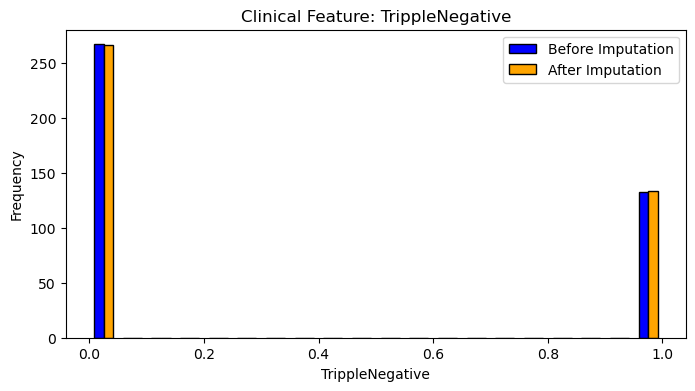

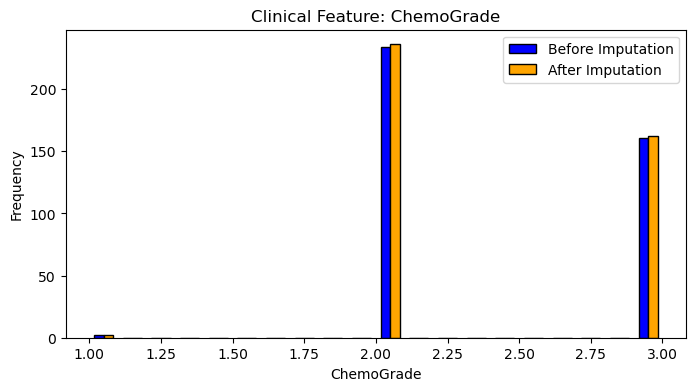

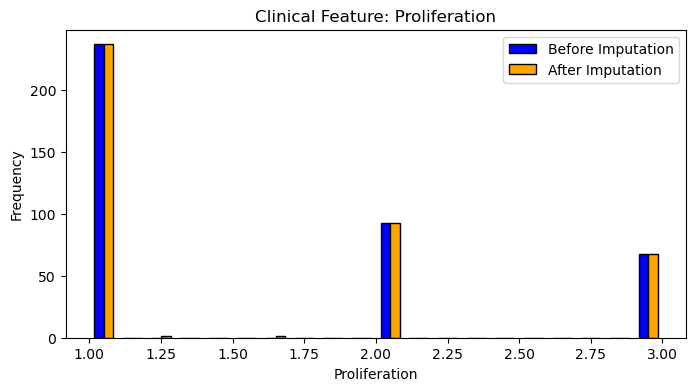

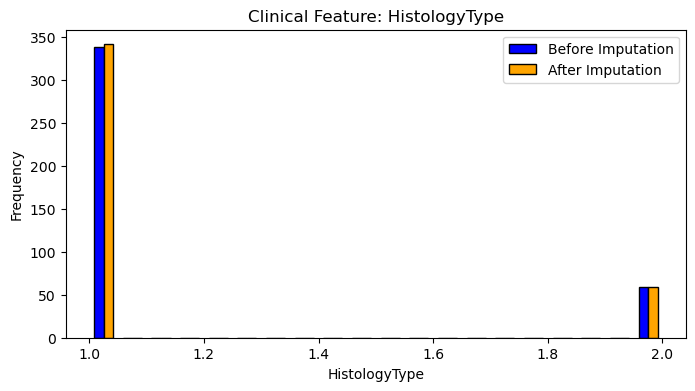

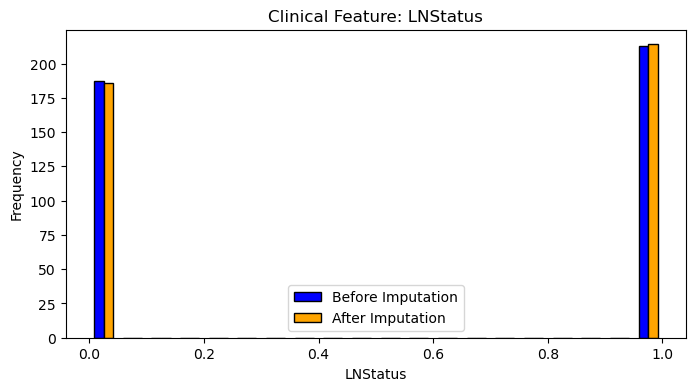

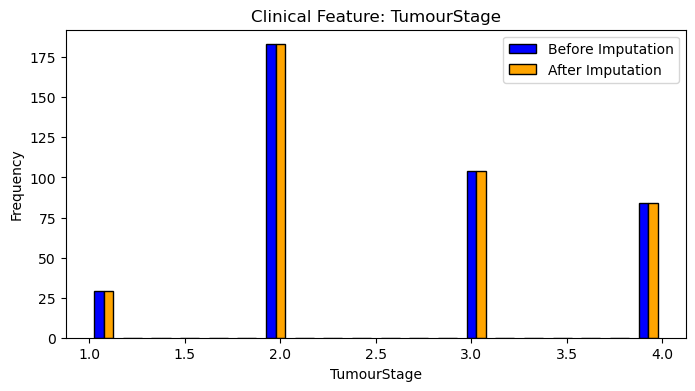

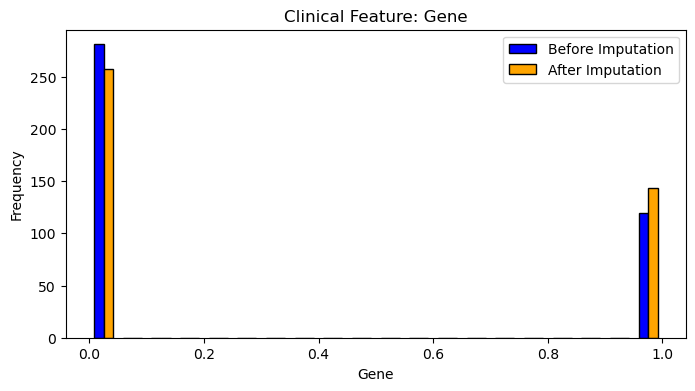

In [3]:
import matplotlib.pyplot as plt
def compare_distributions_safe(data_before, data_after, features, plot_type="histogram", title_prefix="Feature"):
    """
    Compare distributions of features before and after imputation, handling NaNs gracefully.

    Args:
        data_before: DataFrame before imputation.
        data_after: DataFrame after imputation.
        features: List of features to compare.
        plot_type: Type of plot ("histogram" or "density").
        title_prefix: Prefix for each plot's title.
    """
    for feature in features:
        # Ensure feature has valid values in `data_before`
        if data_before[feature].dropna().empty:
            print(f"Feature '{feature}' has no valid values before imputation. Skipping plot.")
            continue
        
        plt.figure(figsize=(8, 4))
        
        if plot_type == "histogram":
            # Define bins and compute histogram values
            bins = np.histogram_bin_edges(data_before[feature].dropna(), bins=20)
            before_hist, _ = np.histogram(data_before[feature].fillna(0), bins=bins)
            after_hist, _ = np.histogram(data_after[feature].fillna(0), bins=bins)

            # Create positions for side-by-side bars
            bin_centers = (bins[:-1] + bins[1:]) / 2
            bar_width = (bins[1] - bins[0]) / 3

            # Plot the histograms side by side
            plt.bar(bin_centers - bar_width / 2, before_hist, width=bar_width, label="Before Imputation", color='blue', edgecolor='black')
            plt.bar(bin_centers + bar_width / 2, after_hist, width=bar_width, label="After Imputation", color='orange', edgecolor='black')
            plt.xlabel(feature)
            plt.ylabel("Frequency")
        
        elif plot_type == "density":
            # Density plot for continuous features
            sns.kdeplot(data_before[feature].dropna(), label="Before Imputation", fill=True, alpha=0.5)
            sns.kdeplot(data_after[feature], label="After Imputation", fill=True, alpha=0.5)
            plt.xlabel(feature)
            plt.ylabel("Density")
        
        # Add title and legend
        plt.title(f"{title_prefix}: {feature}")
        plt.legend()
        plt.show()

# Usage example:
# Compare clinical features with histograms
compare_distributions_safe(data, data_imputed_corrected, clinical_features, plot_type="histogram", title_prefix="Clinical Feature")



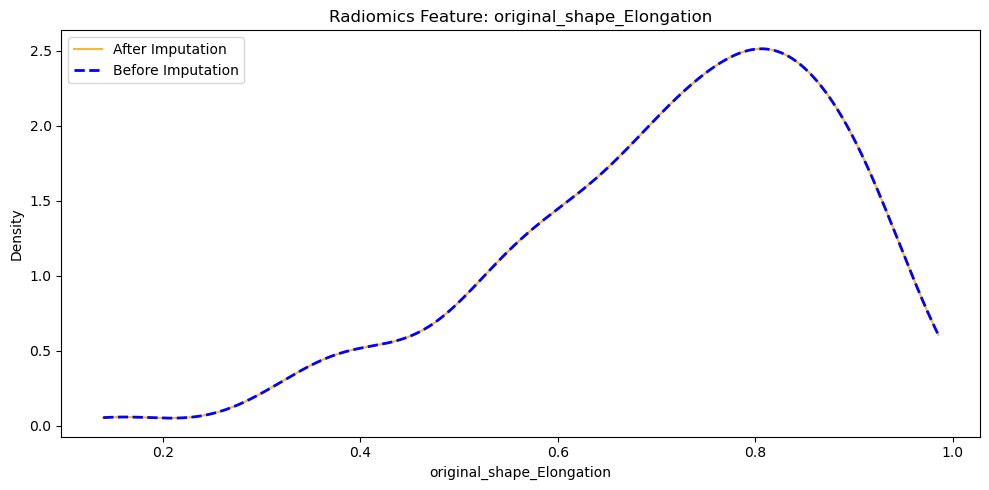

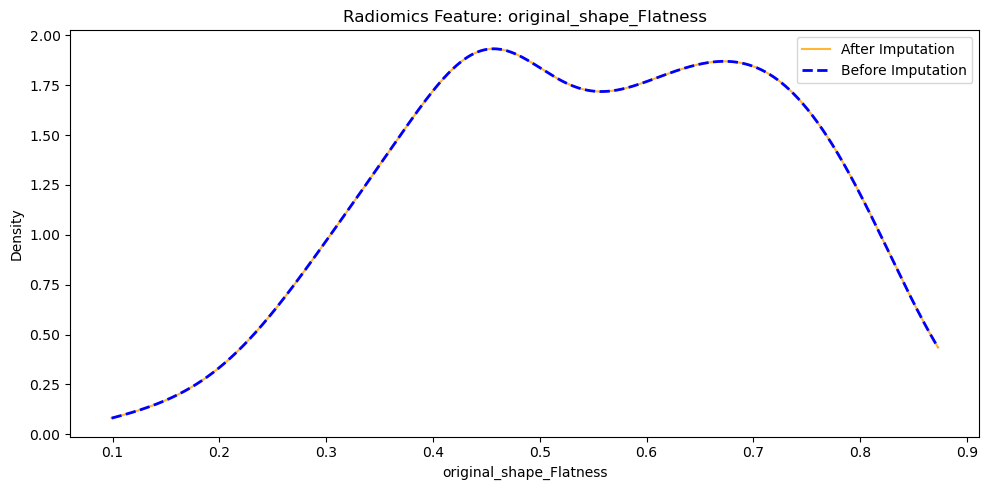

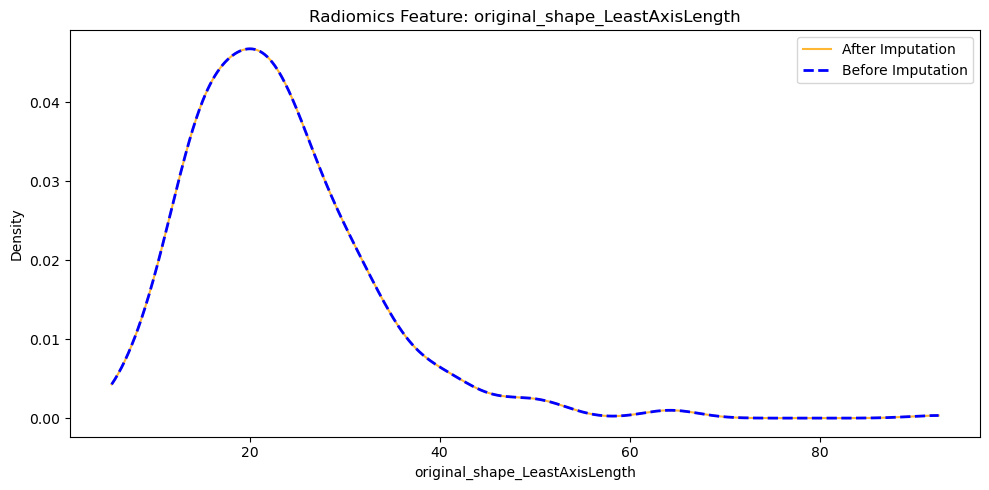

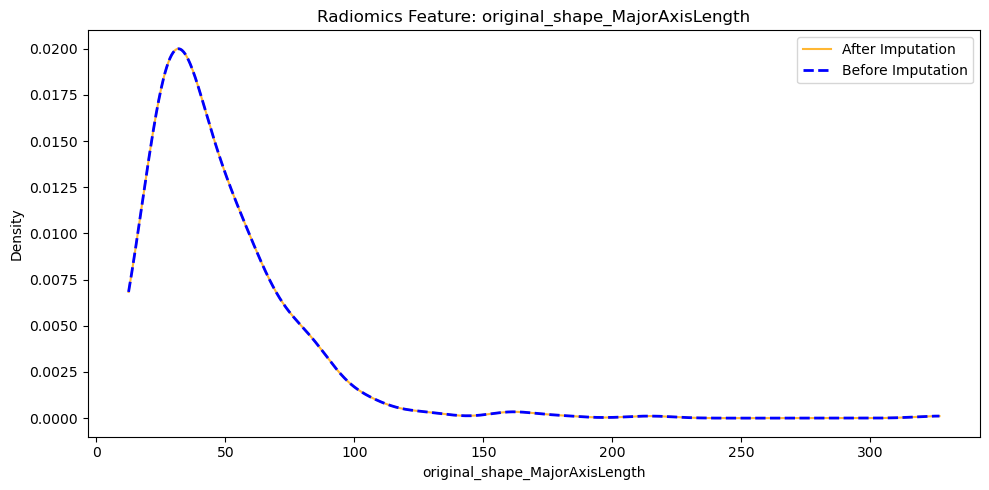

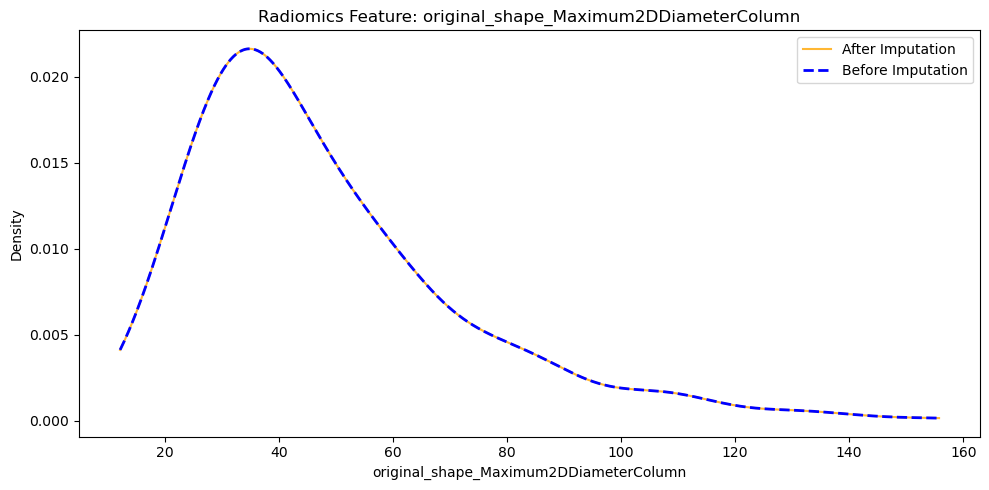

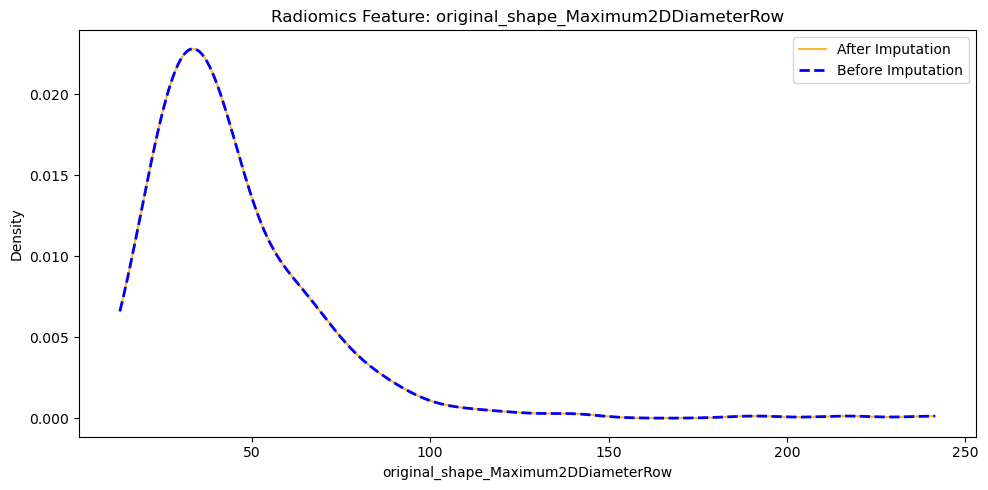

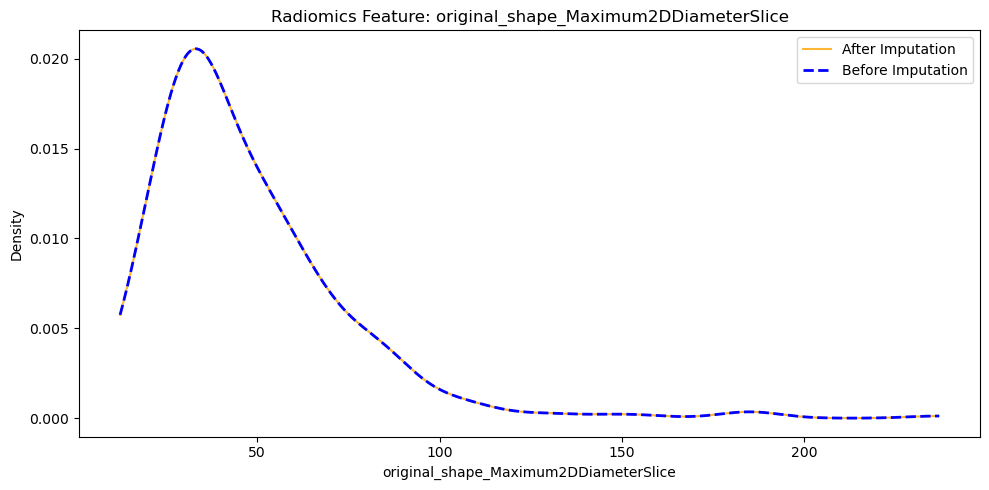

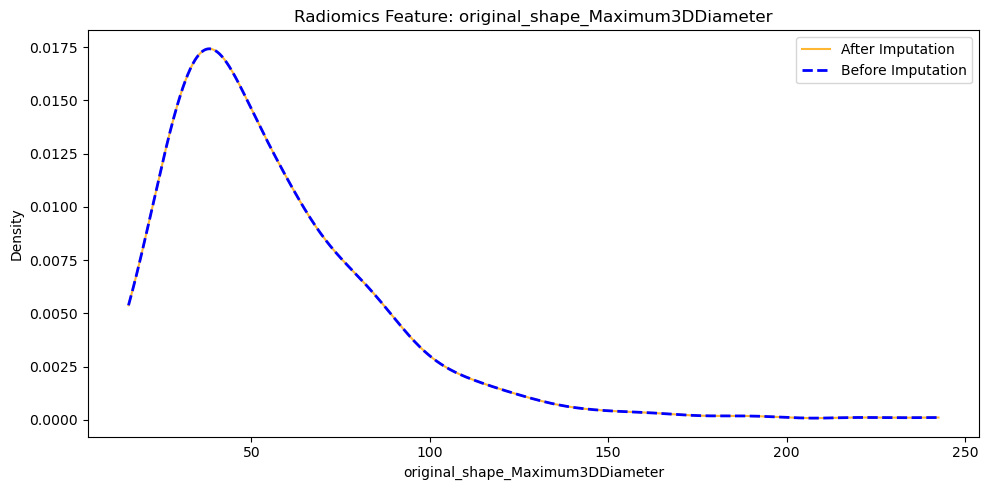

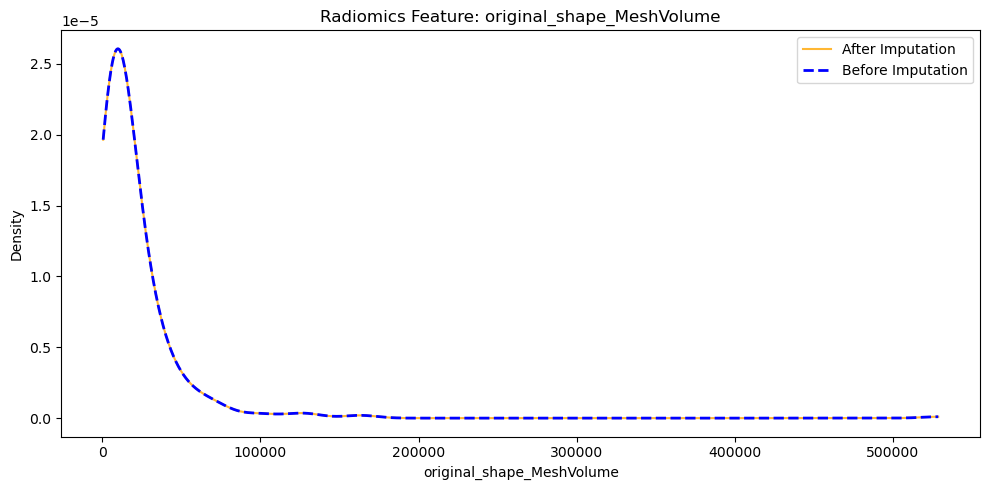

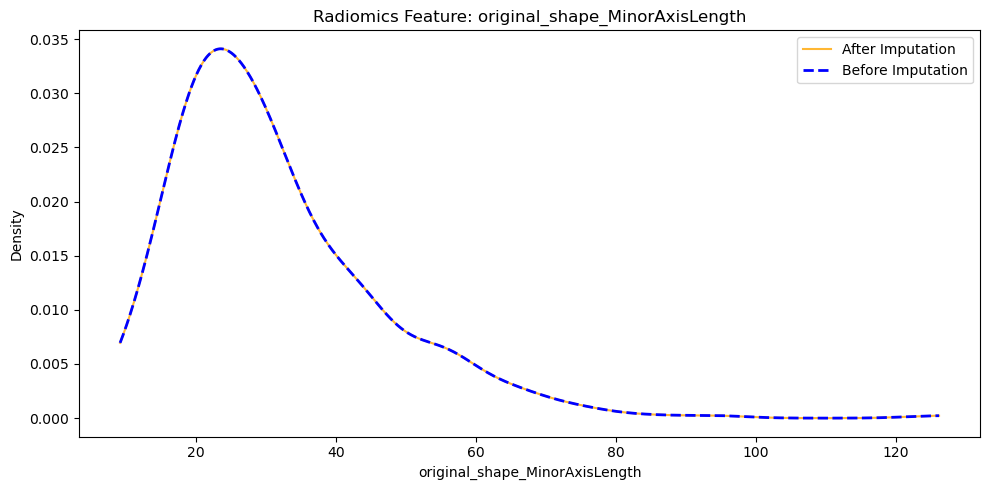

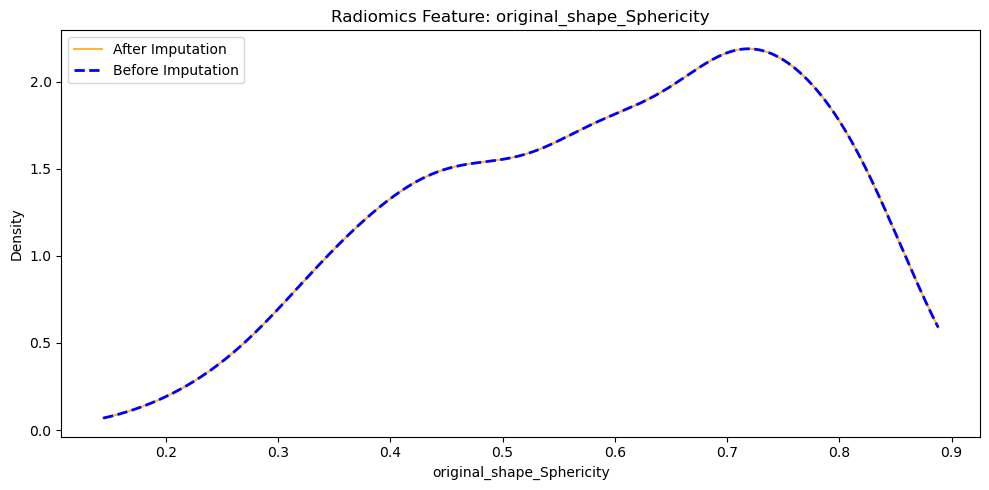

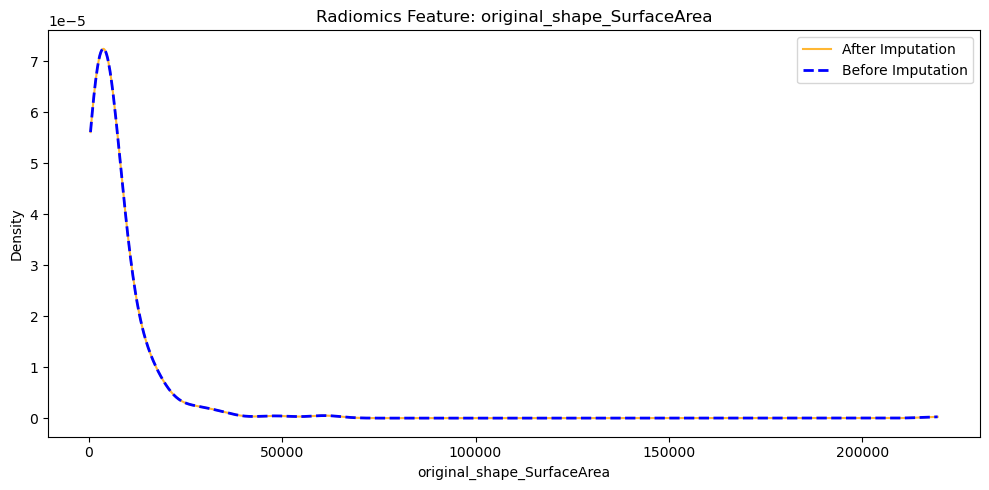

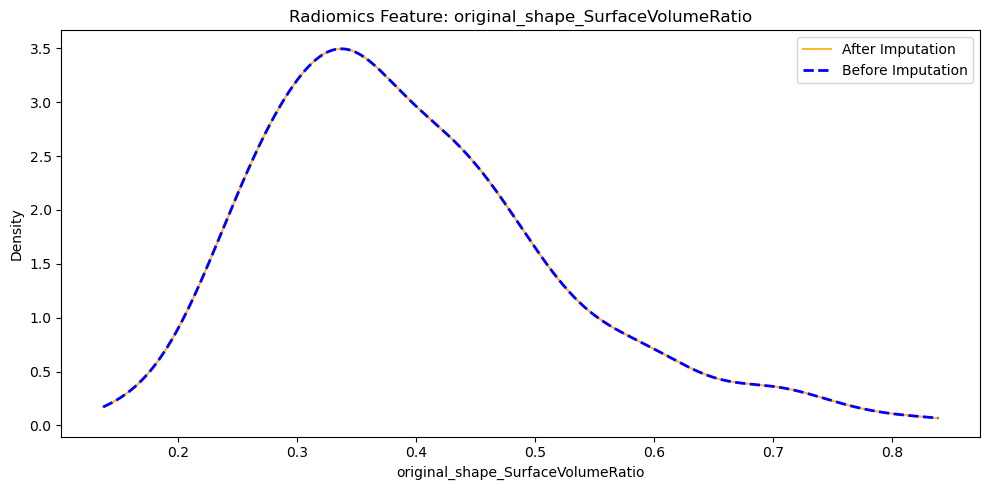

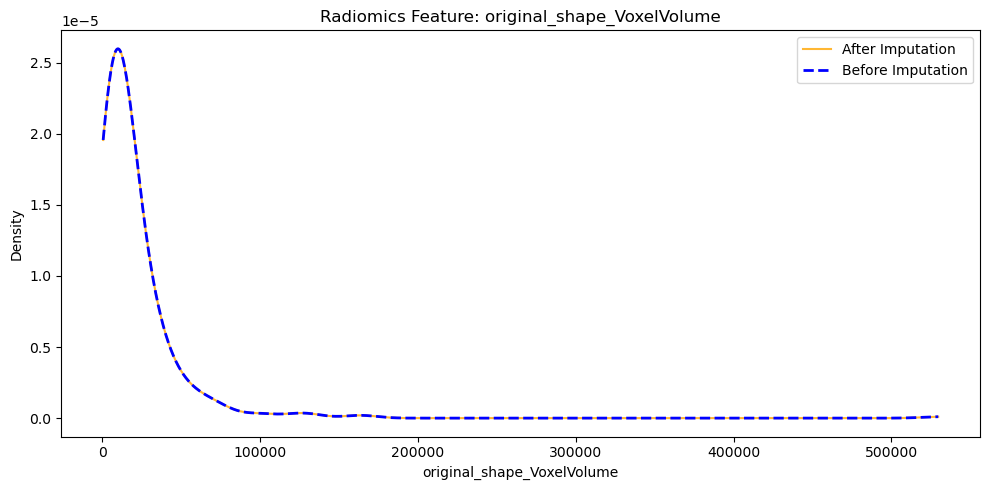

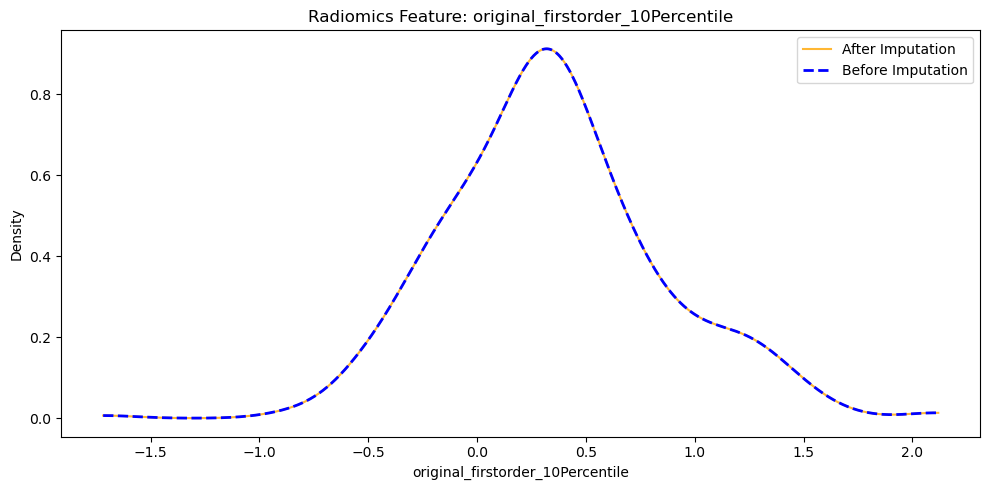

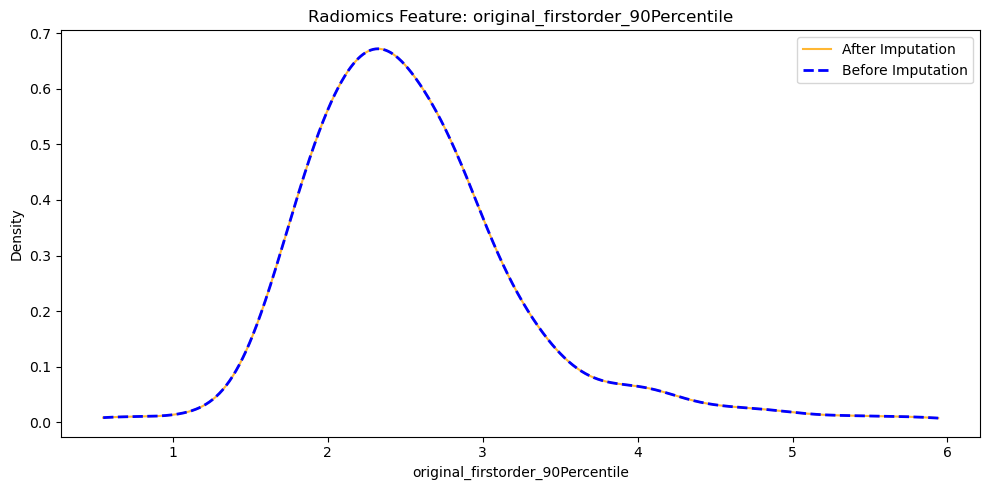

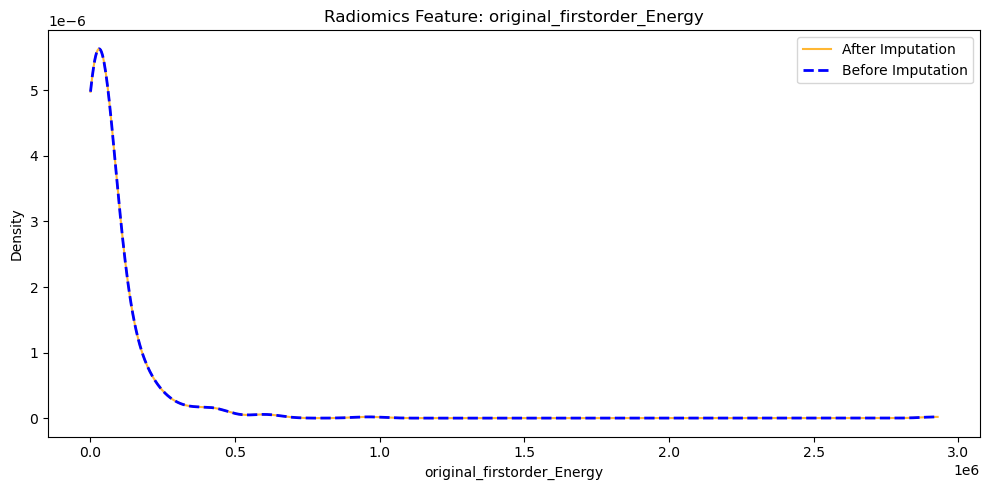

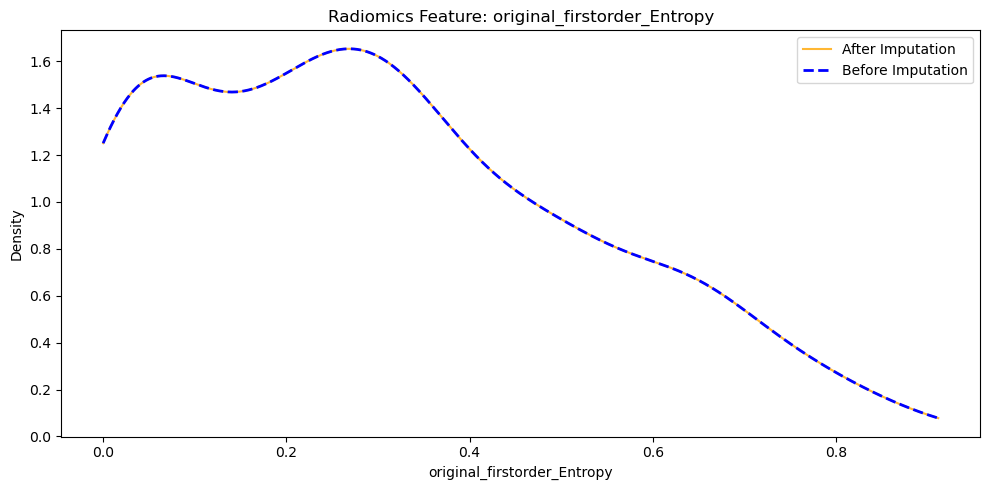

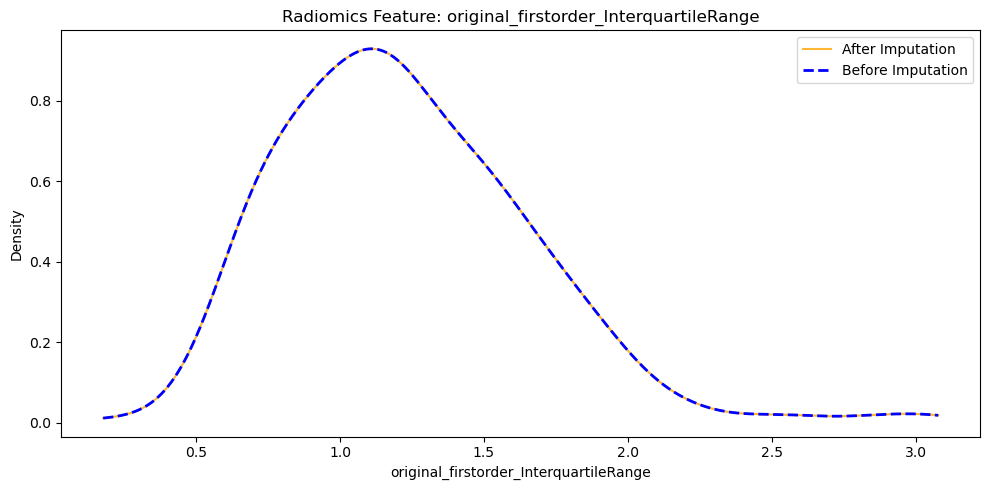

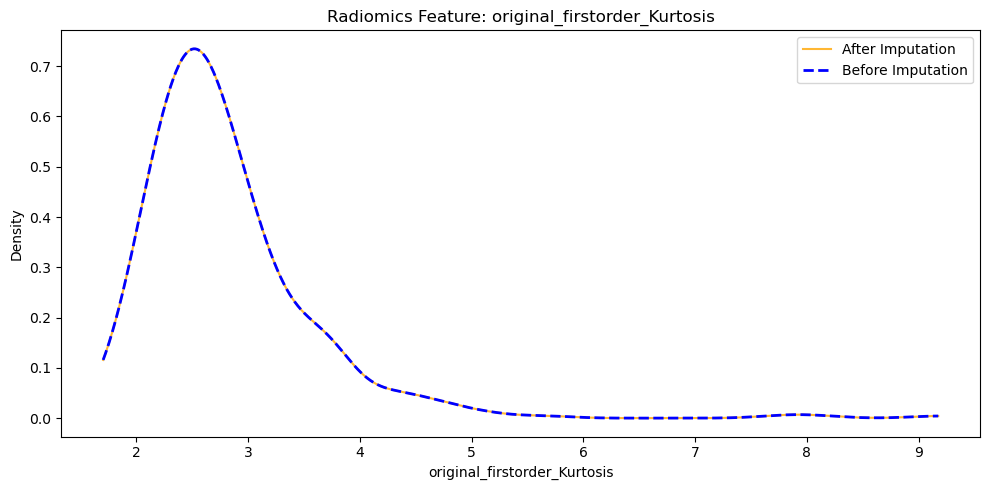

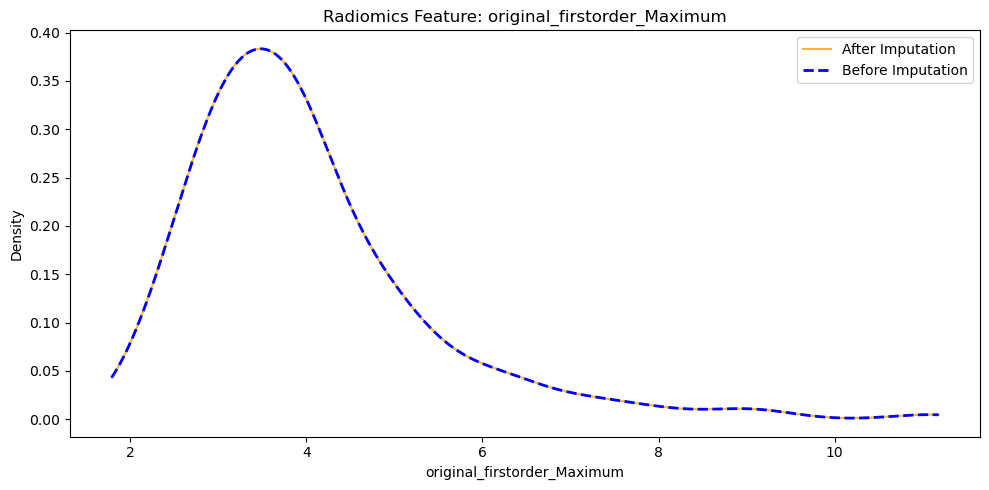

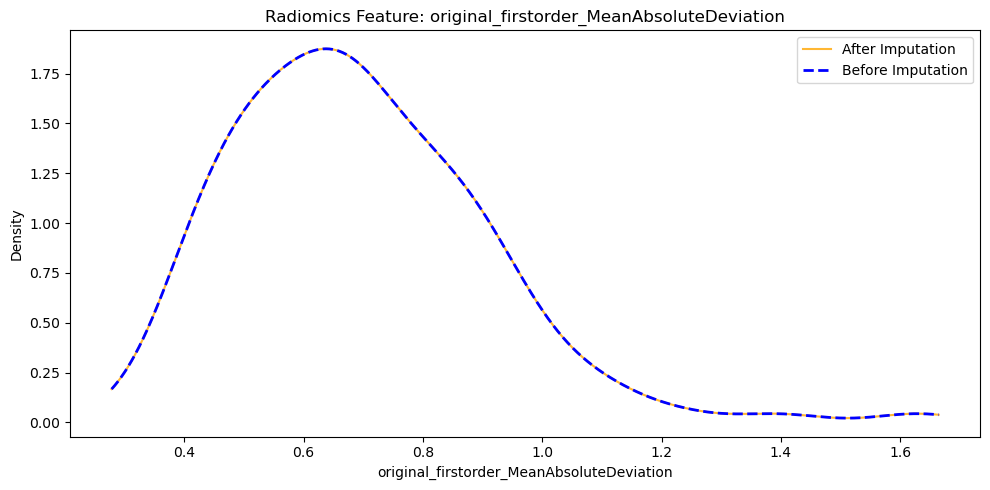

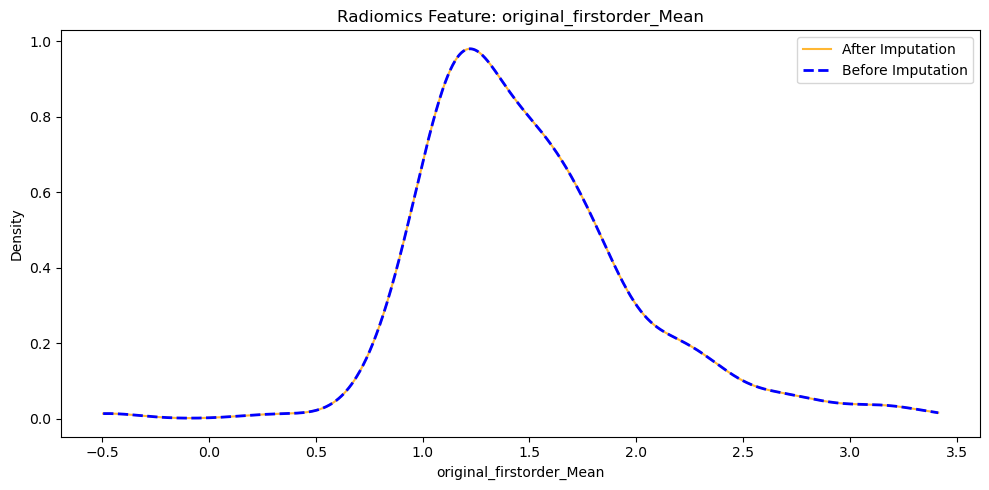

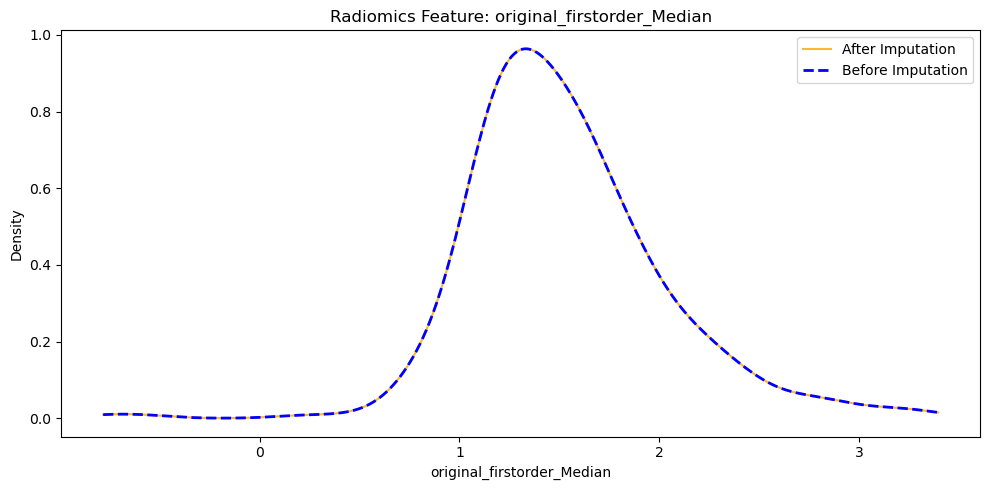

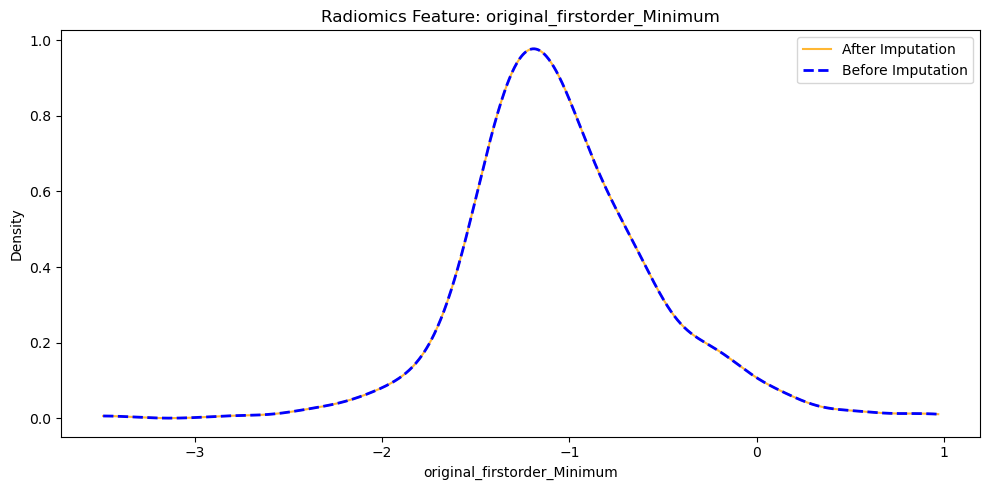

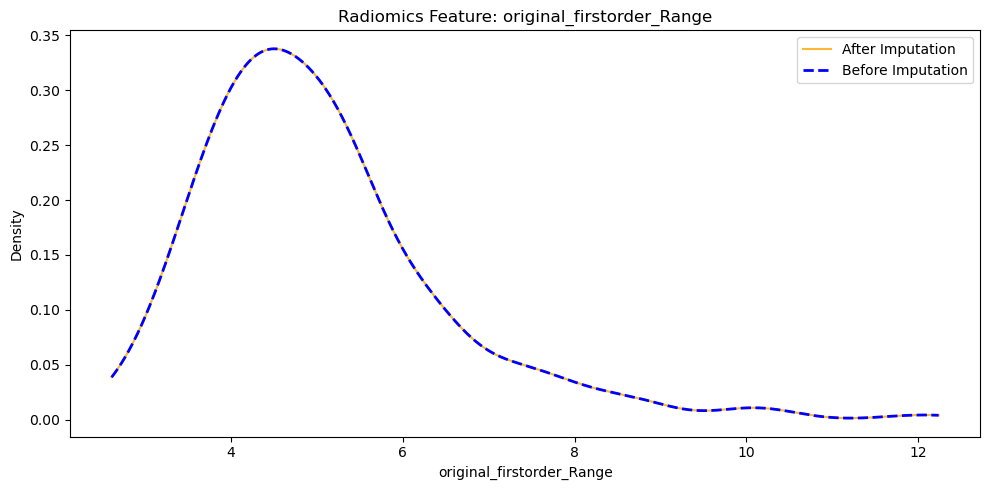

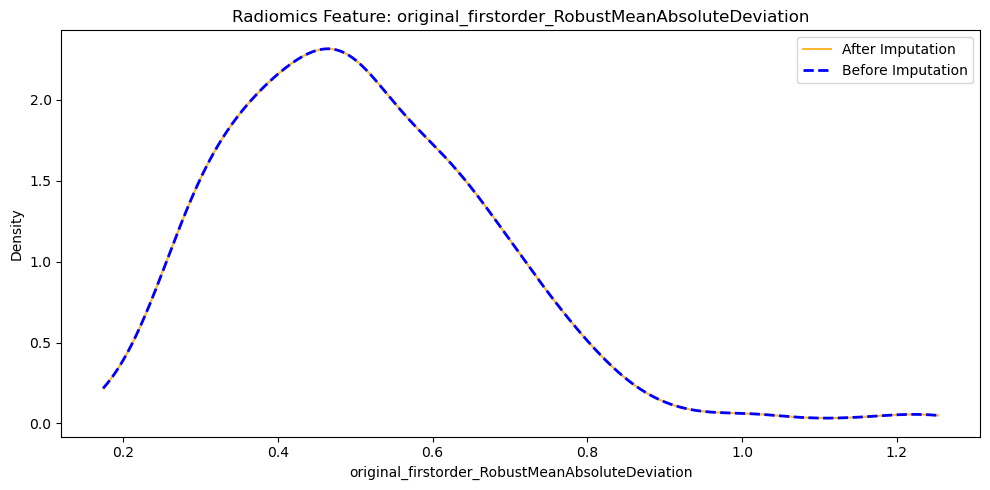

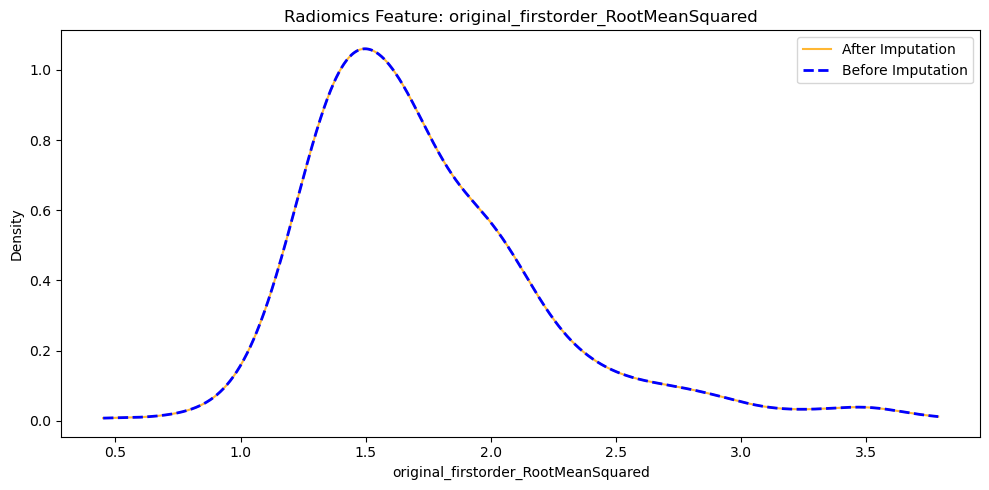

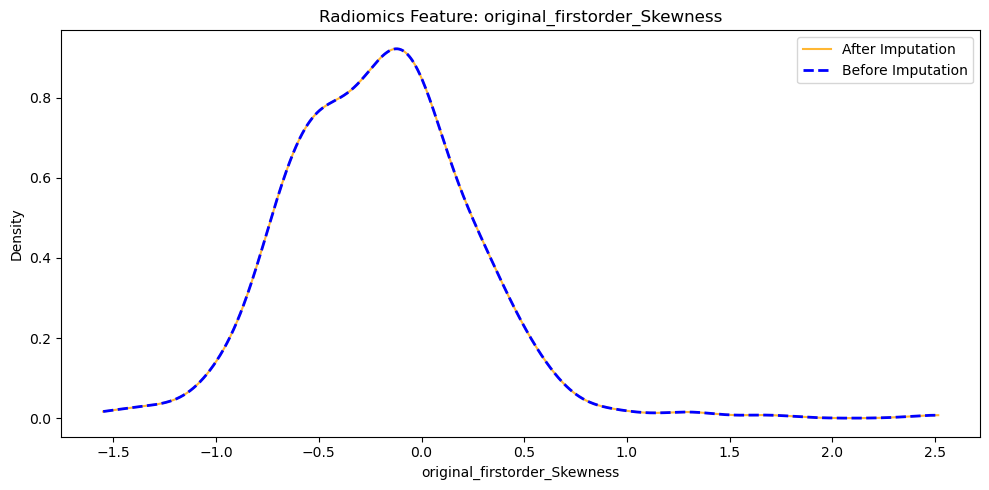

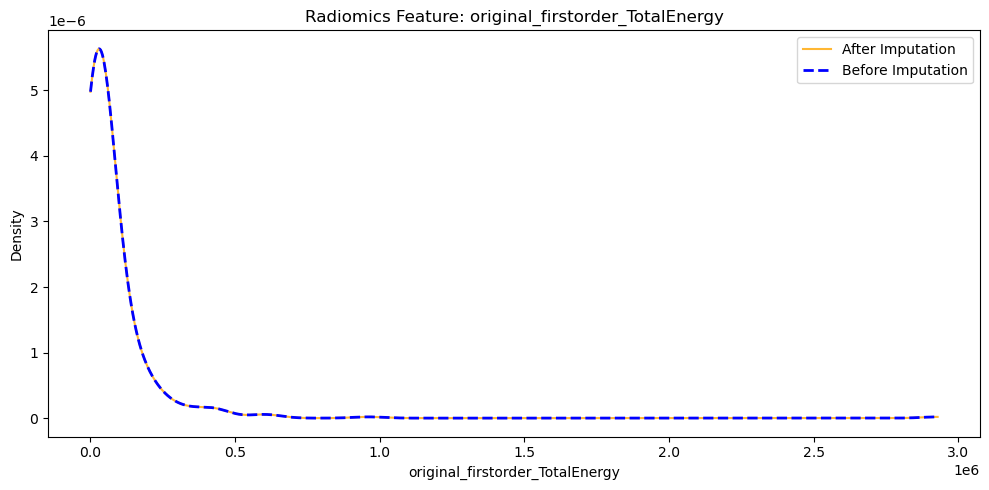

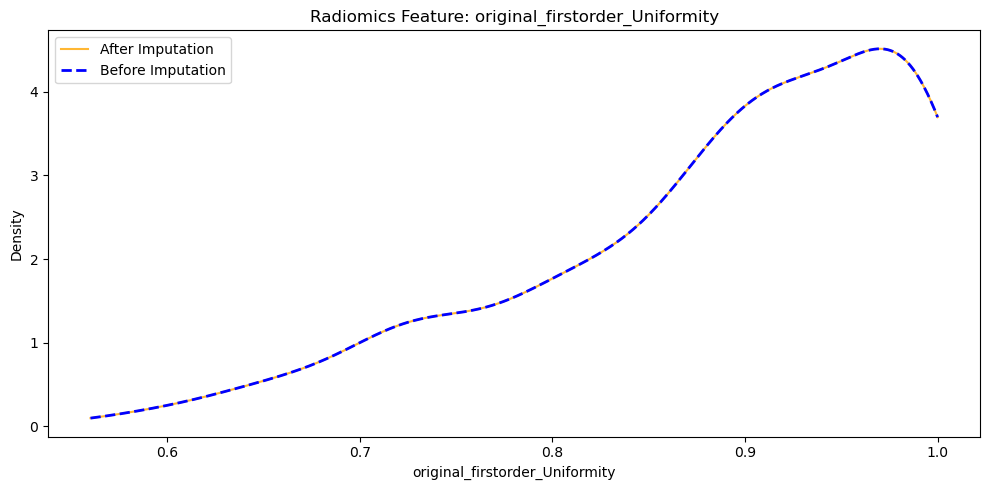

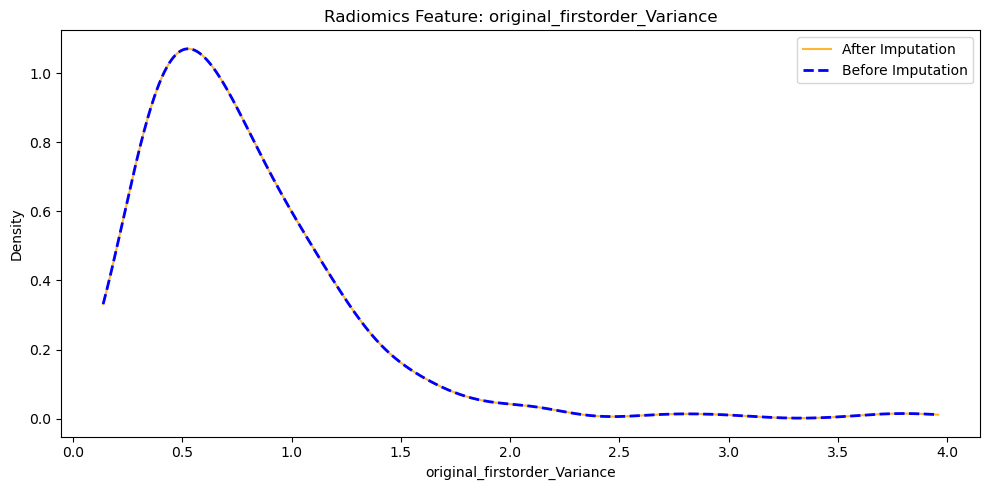

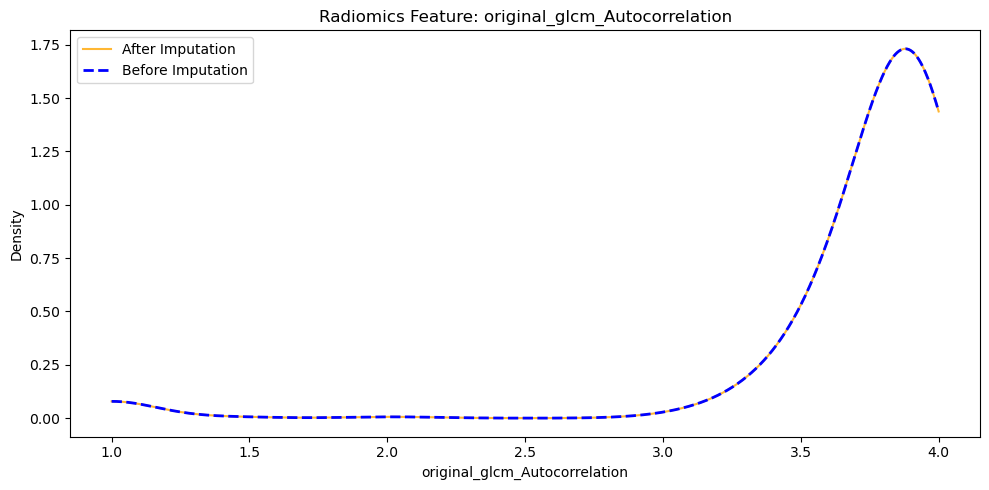

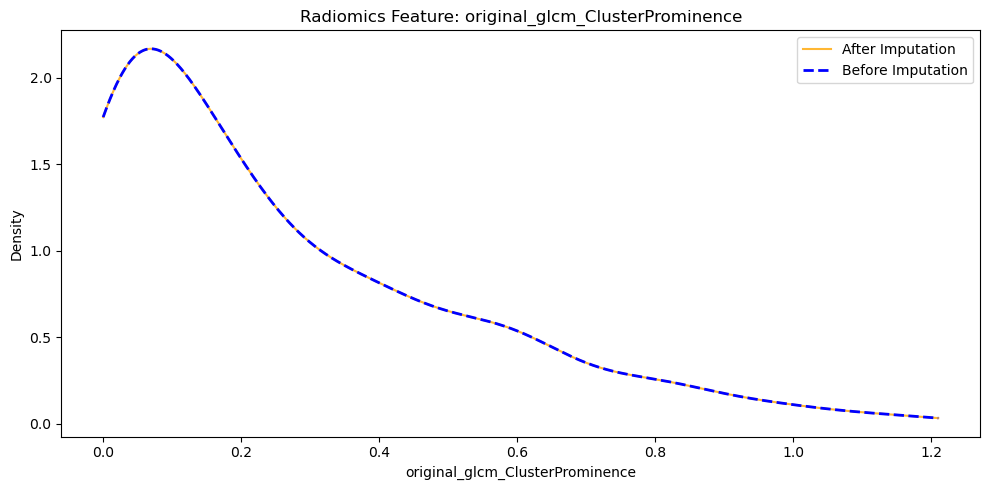

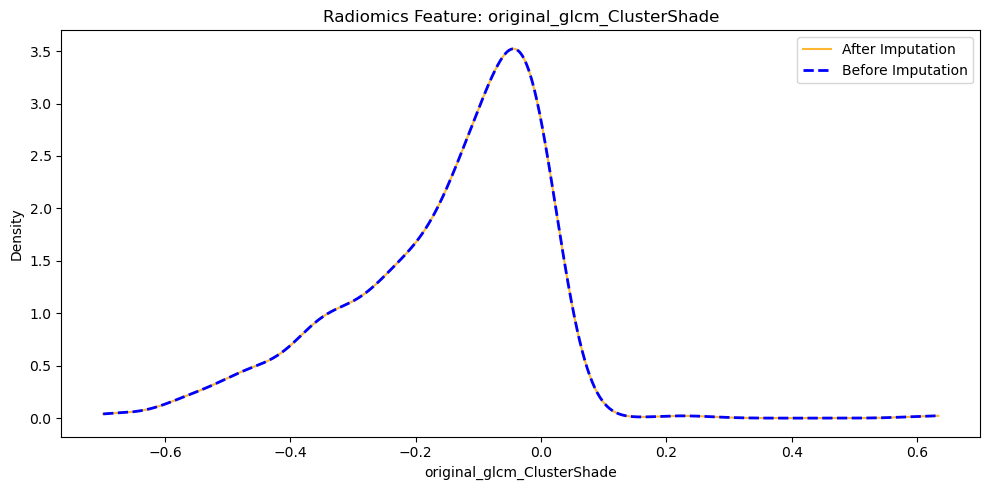

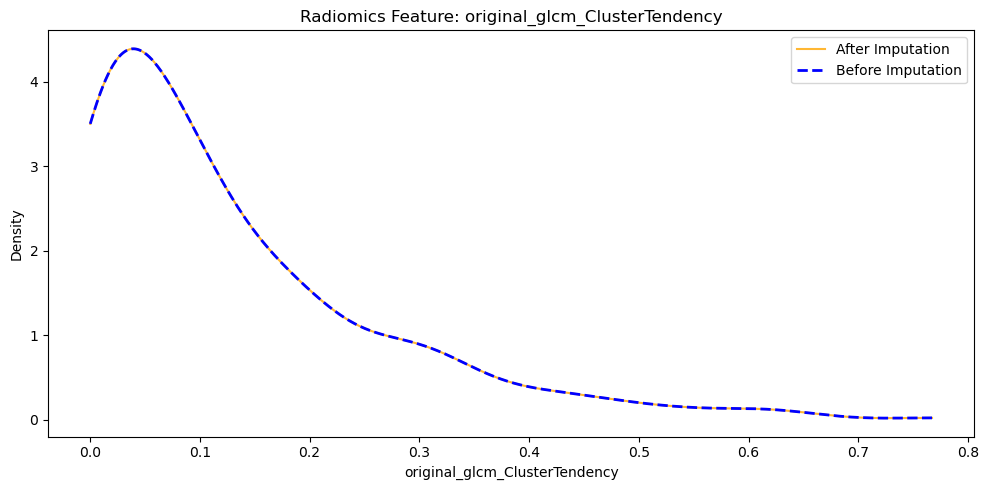

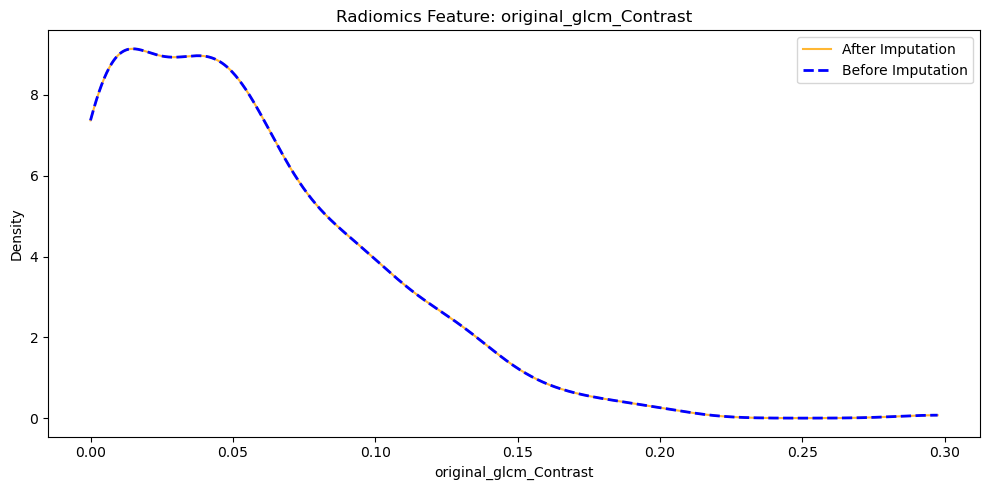

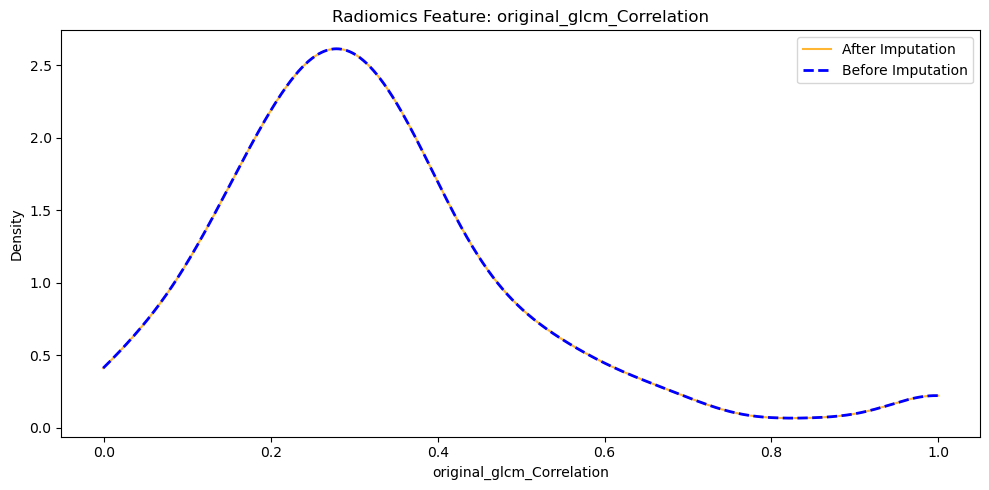

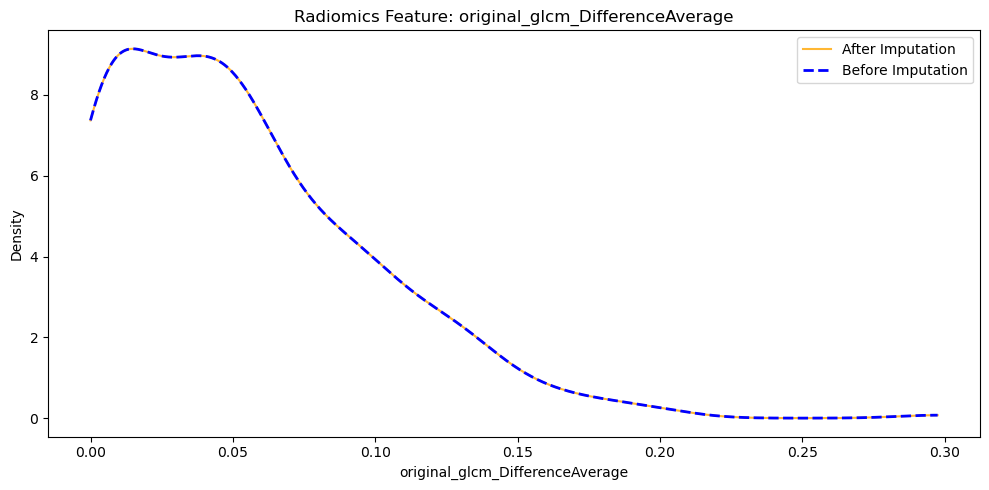

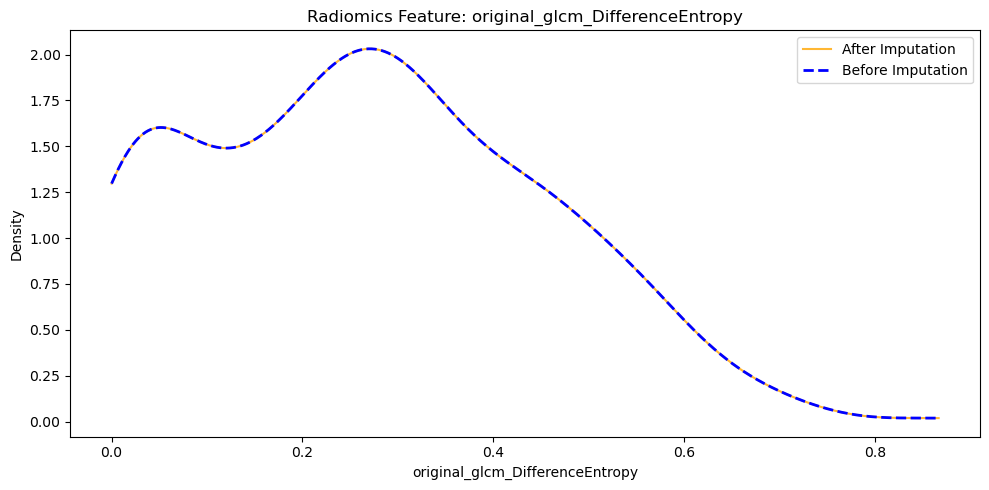

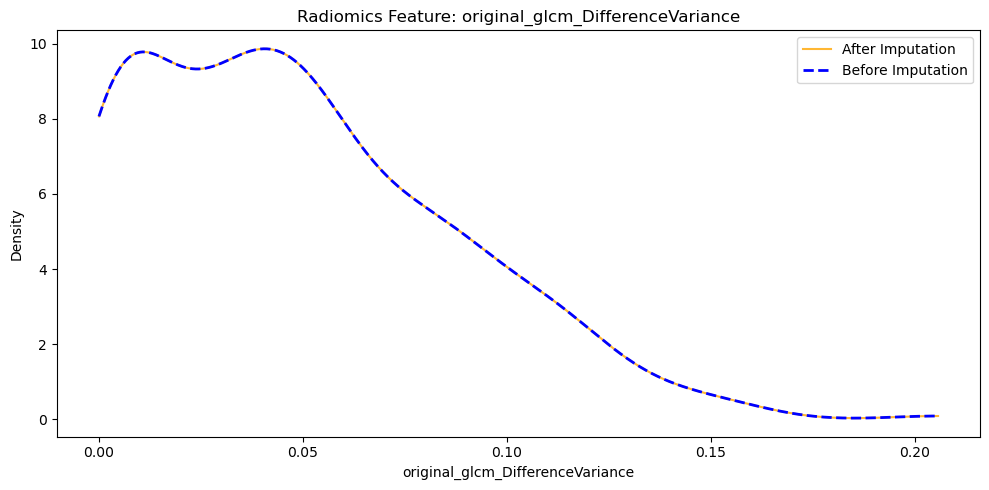

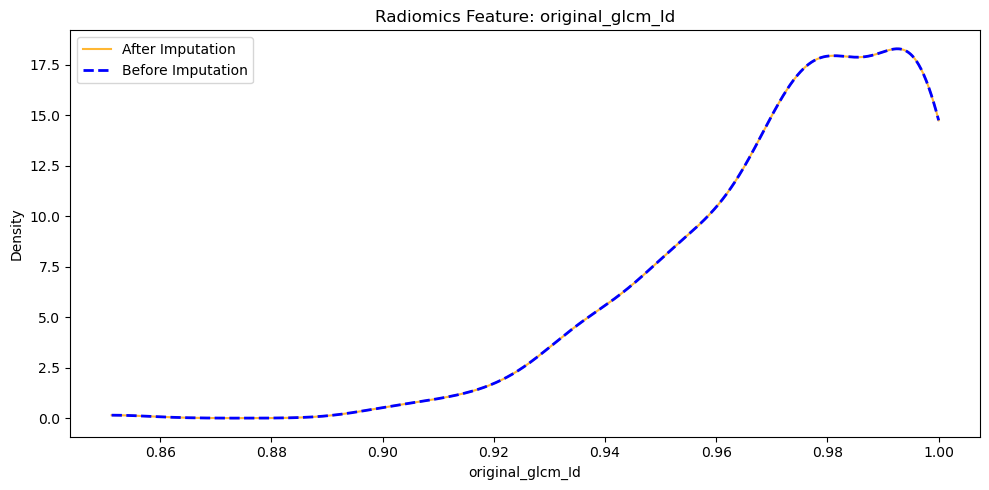

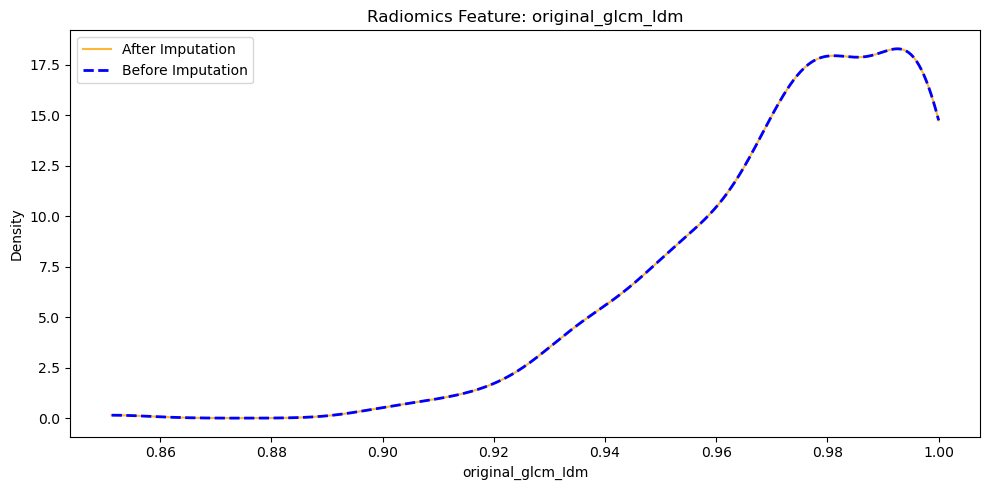

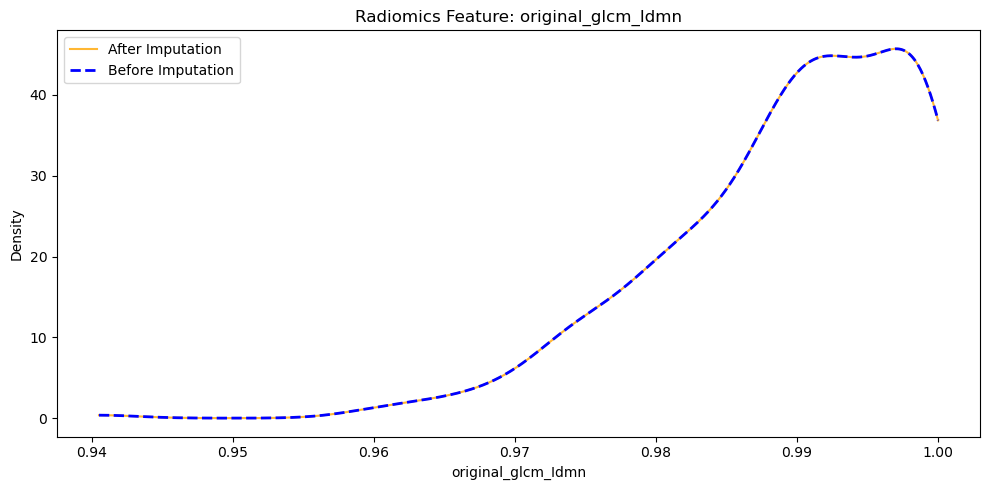

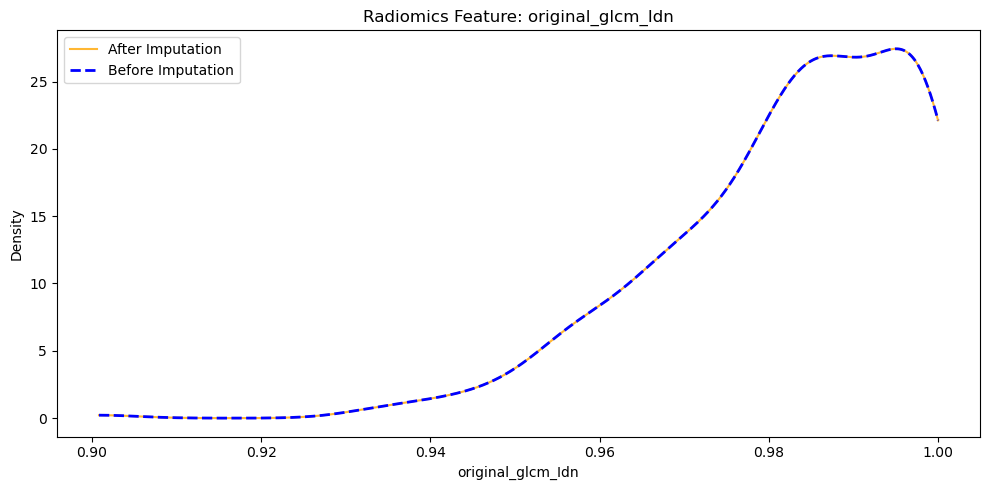

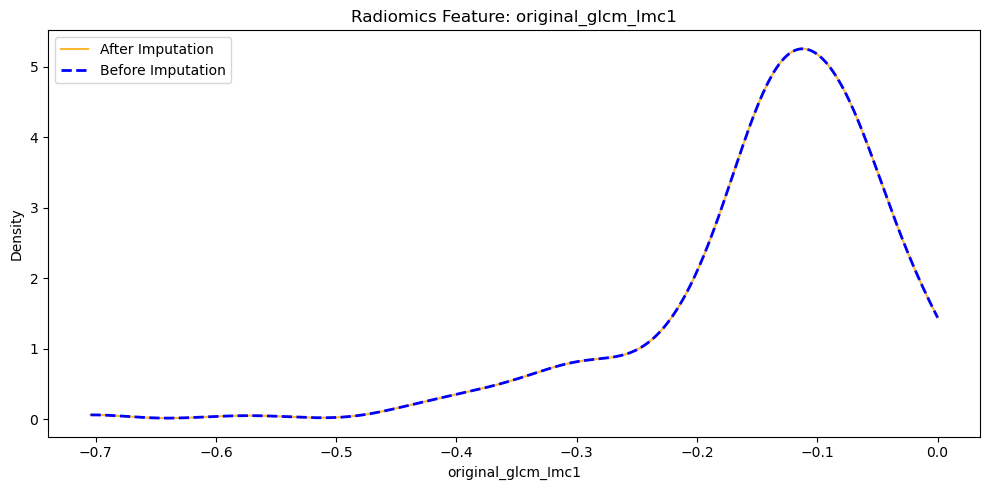

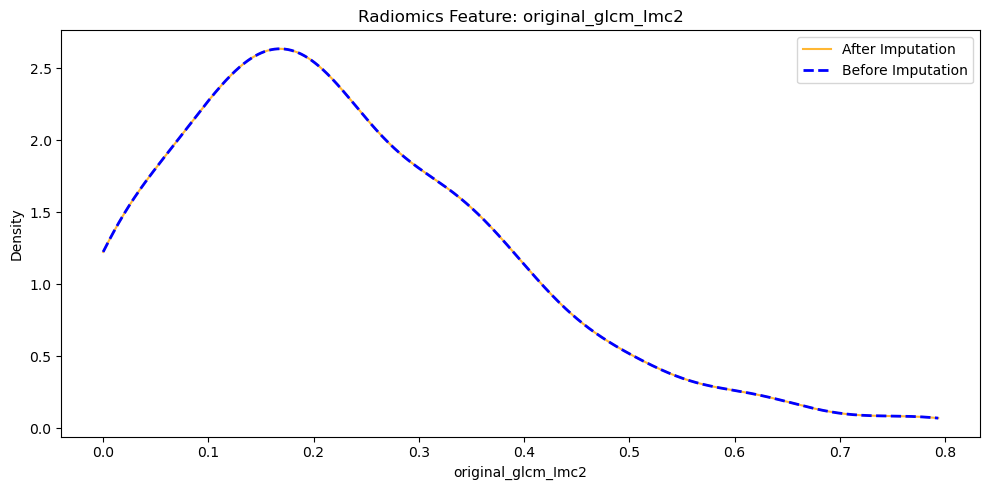

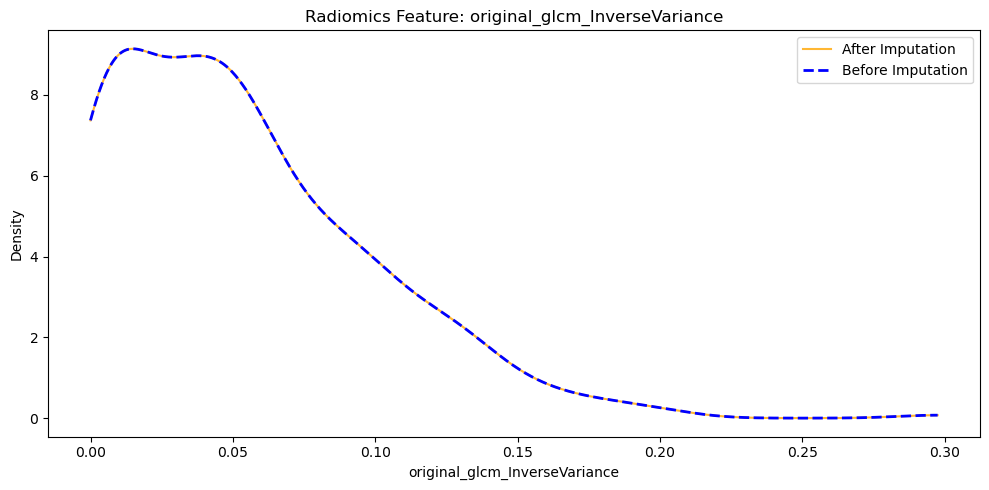

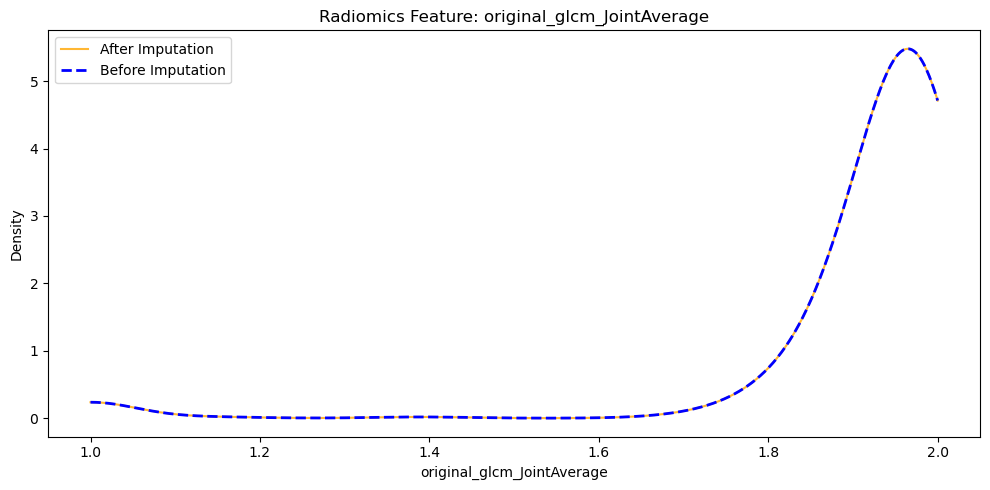

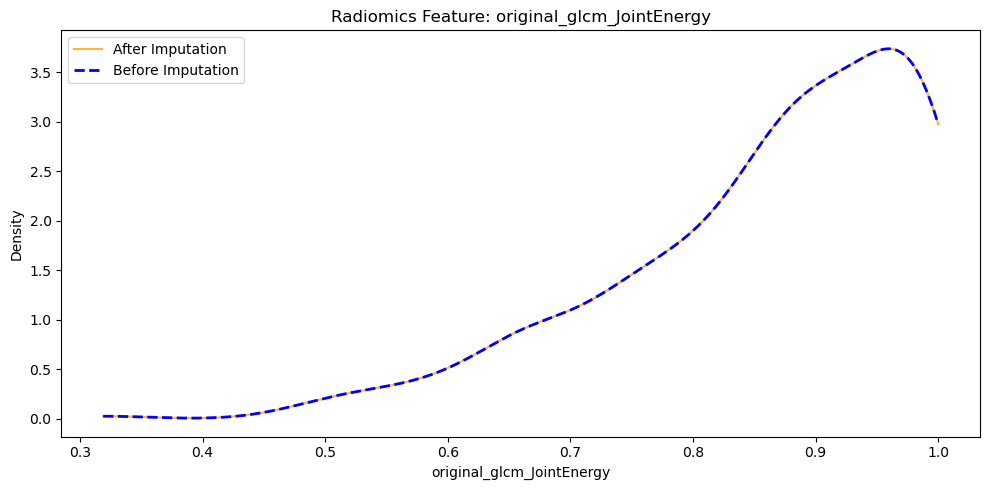

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd

def plot_density_with_style(data_before, data_after, features, title_prefix="Feature"):
    """
    Plot smoothed density plots with styled lines for better comparison.
    
    Args:
        data_before: DataFrame before imputation.
        data_after: DataFrame after imputation.
        features: List of features to plot.
        title_prefix: Prefix for each plot's title.
    """
    for feature in features:
        plt.figure(figsize=(10, 5))
        
        # Compute KDE for before and after imputation
        kde_before = gaussian_kde(data_before[feature].dropna())
        kde_after = gaussian_kde(data_after[feature].dropna())
        
        x_vals = np.linspace(
            min(data_before[feature].min(), data_after[feature].min()),
            max(data_before[feature].max(), data_after[feature].max()),
            1000
        )
        
        # Plot KDE with styles
        plt.plot(x_vals, kde_after(x_vals), label="After Imputation", color='orange', alpha=0.8)
        plt.plot(x_vals, kde_before(x_vals), label="Before Imputation", color='blue', linestyle='--', linewidth=2)
        
        # Add labels and legend
        plt.title(f"{title_prefix}: {feature}")
        plt.xlabel(feature)
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Ensure all selected features are numeric
radiomics_features_sample = radiomics_features[:50]  # Adjust to include the desired subset of features
data_numeric = data[radiomics_features_sample].apply(pd.to_numeric, errors='coerce')
data_imputed_numeric = data_imputed_corrected[radiomics_features_sample].apply(pd.to_numeric, errors='coerce')

# Plot the density comparison
plot_density_with_style(data_numeric, data_imputed_numeric, radiomics_features_sample, title_prefix="Radiomics Feature")


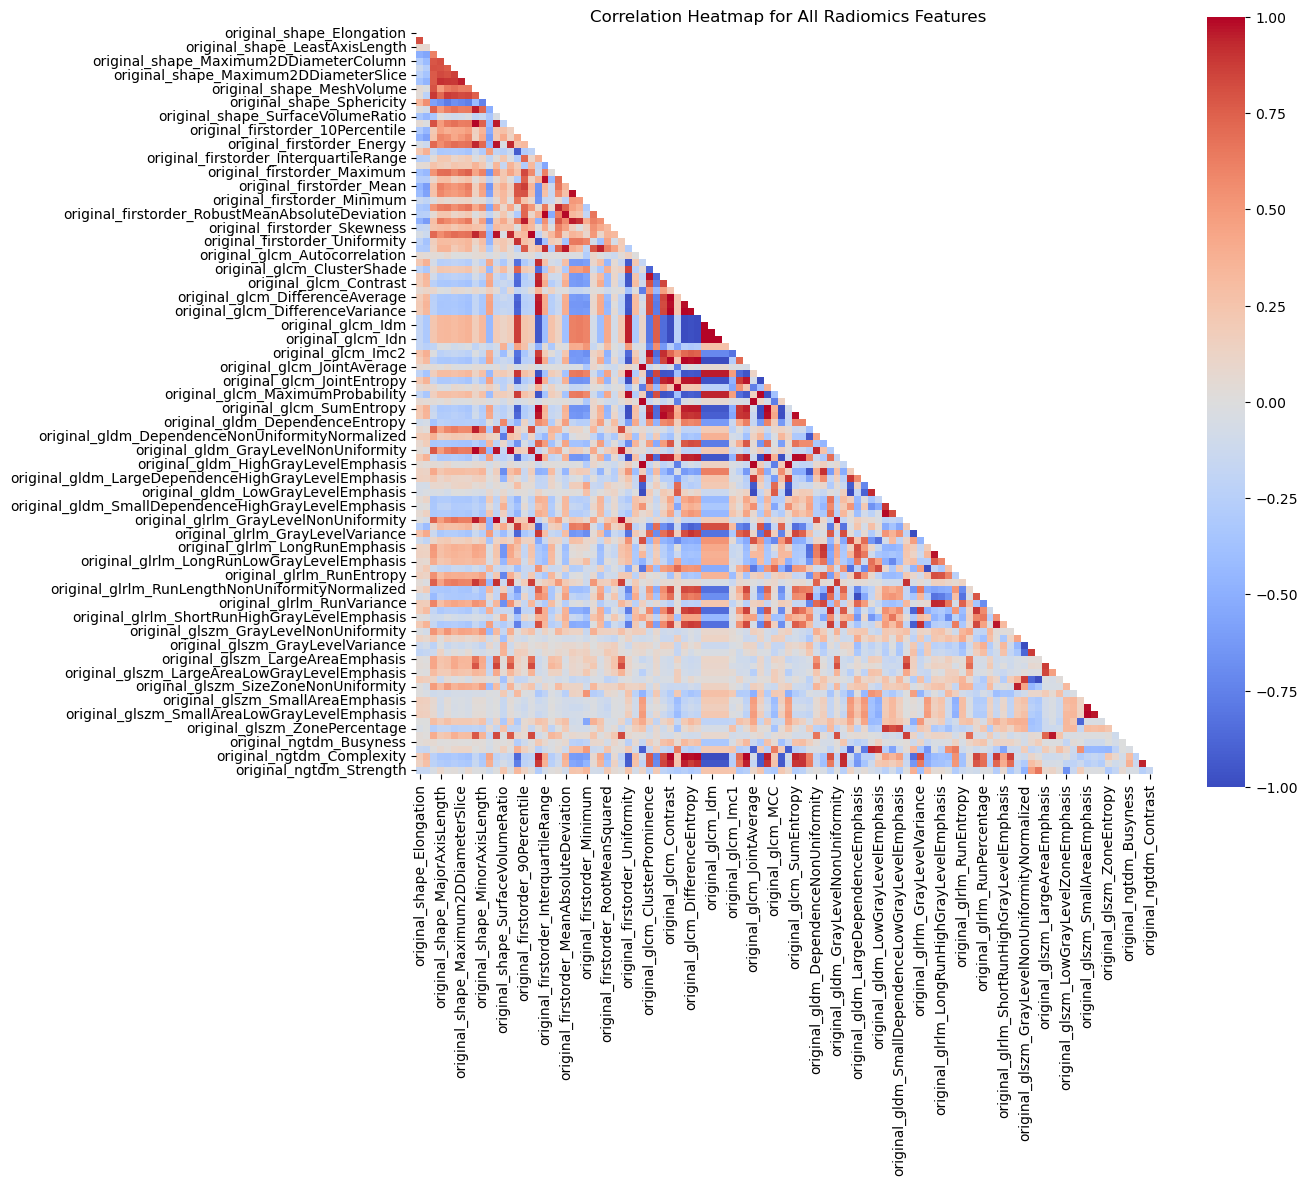

{'Correlation Threshold': 0.9,
 'Number of Correlated Pairs': 548,
 'First 107 Correlated Pairs': [('original_shape_MajorAxisLength',
   'original_shape_Maximum3DDiameter'),
  ('original_shape_Maximum2DDiameterSlice',
   'original_shape_Maximum3DDiameter'),
  ('original_shape_Maximum3DDiameter', 'original_shape_MajorAxisLength'),
  ('original_shape_Maximum3DDiameter',
   'original_shape_Maximum2DDiameterSlice'),
  ('original_shape_MeshVolume', 'original_shape_SurfaceArea'),
  ('original_shape_MeshVolume', 'original_shape_VoxelVolume'),
  ('original_shape_MeshVolume', 'original_firstorder_Energy'),
  ('original_shape_MeshVolume', 'original_firstorder_TotalEnergy'),
  ('original_shape_MeshVolume', 'original_gldm_DependenceNonUniformity'),
  ('original_shape_MeshVolume', 'original_gldm_GrayLevelNonUniformity'),
  ('original_shape_MeshVolume', 'original_glrlm_GrayLevelNonUniformity'),
  ('original_shape_SurfaceArea', 'original_shape_MeshVolume'),
  ('original_shape_SurfaceArea', 'original_

In [5]:
import seaborn as sns

# Step 1: Compute the correlation matrix for all radiomics features
# Define the correlation threshold again
correlation_threshold = 0.9

# Compute the correlation matrix for all radiomics features
all_radiomics_data = data_imputed_corrected[radiomics_features].apply(pd.to_numeric, errors='coerce')
correlation_matrix_all = all_radiomics_data.corr()

# Mask the upper triangle of the correlation matrix for better readability
mask = np.triu(np.ones_like(correlation_matrix_all, dtype=bool))

# Plot the correlation heatmap with masking
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix_all,
    mask=mask,
    cmap="coolwarm",
    annot=False,
    fmt=".2f",
    cbar=True,
    square=True
)
plt.title("Correlation Heatmap for All Radiomics Features")
plt.show()

# Identify pairs of features with high correlation above the threshold
high_correlation_pairs_all = [
    (col1, col2)
    for col1 in correlation_matrix_all.columns
    for col2 in correlation_matrix_all.columns
    if col1 != col2 and abs(correlation_matrix_all.loc[col1, col2]) > correlation_threshold
]

# Summarize highly correlated pairs
high_correlation_pairs_all_summary = {
    "Correlation Threshold": correlation_threshold,
    "Number of Correlated Pairs": len(high_correlation_pairs_all),
    "First 107 Correlated Pairs": high_correlation_pairs_all[:107]  # Display first 10 pairs as an example
}

high_correlation_pairs_all_summary


In [6]:
# Function to retain one feature from each highly correlated group
def retain_uncorrelated_features(correlation_matrix, threshold):
    """
    Retain one feature from each group of highly correlated features.

    Args:
        correlation_matrix: DataFrame containing the correlation matrix.
        threshold: Correlation threshold for considering features as highly correlated.

    Returns:
        List of selected features.
    """
    # Track features to drop
    features_to_drop = set()
    selected_features = []

    # Iterate through features in order of appearance
    for col in correlation_matrix.columns:
        if col not in features_to_drop:
            # Add the current feature to selected features
            selected_features.append(col)

            # Find features highly correlated with the current feature
            highly_correlated = correlation_matrix.index[
                abs(correlation_matrix[col]) > threshold
            ].tolist()

            # Exclude the current feature and add others to the drop list
            highly_correlated.remove(col)
            features_to_drop.update(highly_correlated)

    return selected_features

# Apply the function to retain uncorrelated features
selected_features = retain_uncorrelated_features(correlation_matrix_all, correlation_threshold)

# Summary of feature selection
feature_selection_summary = {
    "Total Features": len(radiomics_features),
    "Selected Features": len(selected_features),
    "Dropped Features": len(radiomics_features) - len(selected_features)
}

selected_features[:107], feature_selection_summary  # Display the first 10 selected features and summary


(['original_shape_Elongation',
  'original_shape_Flatness',
  'original_shape_LeastAxisLength',
  'original_shape_MajorAxisLength',
  'original_shape_Maximum2DDiameterColumn',
  'original_shape_Maximum2DDiameterRow',
  'original_shape_Maximum2DDiameterSlice',
  'original_shape_MeshVolume',
  'original_shape_MinorAxisLength',
  'original_shape_Sphericity',
  'original_shape_SurfaceVolumeRatio',
  'original_firstorder_10Percentile',
  'original_firstorder_90Percentile',
  'original_firstorder_InterquartileRange',
  'original_firstorder_Kurtosis',
  'original_firstorder_Maximum',
  'original_firstorder_Mean',
  'original_firstorder_Minimum',
  'original_firstorder_Skewness',
  'original_firstorder_Uniformity',
  'original_glcm_Autocorrelation',
  'original_glcm_ClusterShade',
  'original_glcm_Correlation',
  'original_glcm_Imc1',
  'original_glcm_Imc2',
  'original_gldm_DependenceEntropy',
  'original_gldm_DependenceVariance',
  'original_gldm_LargeDependenceHighGrayLevelEmphasis',
  'ori

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define clinical features
clinical_features = [
    "Age", "ER", "PgR", "HER2", "TrippleNegative", "ChemoGrade",
    "Proliferation", "HistologyType", "LNStatus", "TumourStage", "Gene"
]

# Ensure the target column has no missing values and define cleaned dataset
data_cleaned = data_imputed_corrected.dropna(subset=["pCR (outcome)"])

# Prepare target variables and selected radiomics features
selected_radiomics_features = selected_features  # Features retained after correlation analysis
target_pcr = data_cleaned["pCR (outcome)"].astype(int)  # Classification target
target_rfs = data_cleaned["RelapseFreeSurvival (outcome)"]  # Regression target
X_clinical = data_cleaned[clinical_features]
X_radiomics = data_cleaned[selected_radiomics_features]

# Split data for PCR (classification) and RFS (regression) tasks
X_train_clinical_pcr, X_test_clinical_pcr, y_train_pcr, y_test_pcr = train_test_split(
    X_clinical, target_pcr, test_size=0.2, random_state=42
)
X_train_radiomics_pcr, X_test_radiomics_pcr, _, _ = train_test_split(
    X_radiomics, target_pcr, test_size=0.2, random_state=42
)

X_train_clinical_rfs, X_test_clinical_rfs, y_train_rfs, y_test_rfs = train_test_split(
    X_clinical, target_rfs, test_size=0.2, random_state=42
)
X_train_radiomics_rfs, X_test_radiomics_rfs, _, _ = train_test_split(
    X_radiomics, target_rfs, test_size=0.2, random_state=42
)

# Function to train models and extract feature importance
def train_model_and_get_importance(model, X_train, y_train, feature_names):
    """
    Train a model and extract feature importance.
    Args:
        model: A scikit-learn model with feature importance attribute.
        X_train: Training data (features).
        y_train: Training data (target).
        feature_names: List of feature names.

    Returns:
        DataFrame with feature names and importance scores.
    """
    model.fit(X_train, y_train)
    importance = model.feature_importances_
    return pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False)

# Train Random Forest models for PCR and RFS
rf_classifier = RandomForestClassifier(random_state=42)
rf_regressor = RandomForestRegressor(random_state=42)

clinical_importance_pcr = train_model_and_get_importance(rf_classifier, X_train_clinical_pcr, y_train_pcr, clinical_features)
radiomics_importance_pcr = train_model_and_get_importance(rf_classifier, X_train_radiomics_pcr, y_train_pcr, selected_radiomics_features)
clinical_importance_rfs = train_model_and_get_importance(rf_regressor, X_train_clinical_rfs, y_train_rfs, clinical_features)
radiomics_importance_rfs = train_model_and_get_importance(rf_regressor, X_train_radiomics_rfs, y_train_rfs, selected_radiomics_features)

# Display results
print("Clinical Feature Importance for PCR (Classification):")
print(clinical_importance_pcr.head(10))
print("\nRadiomics Feature Importance for PCR (Classification):")
print(radiomics_importance_pcr.head(10))
print("\nClinical Feature Importance for RFS (Regression):")
print(clinical_importance_rfs.head(10))
print("\nRadiomics Feature Importance for RFS (Regression):")
print(radiomics_importance_rfs.head(10))


Clinical Feature Importance for PCR (Classification):
          Feature  Importance
0             Age    0.375774
9     TumourStage    0.124681
10           Gene    0.124318
6   Proliferation    0.083731
3            HER2    0.055598
8        LNStatus    0.055102
1              ER    0.048272
2             PgR    0.041548
5      ChemoGrade    0.036654
7   HistologyType    0.033404

Radiomics Feature Importance for PCR (Classification):
                                   Feature  Importance
13  original_firstorder_InterquartileRange    0.033987
18            original_firstorder_Skewness    0.028355
35   original_glrlm_RunLengthNonUniformity    0.028152
45        original_glszm_SmallAreaEmphasis    0.028048
5      original_shape_Maximum2DDiameterRow    0.026088
14            original_firstorder_Kurtosis    0.025760
16                original_firstorder_Mean    0.025481
12        original_firstorder_90Percentile    0.025331
1                  original_shape_Flatness    0.025003
9         

C:\Users\sachi\AppData\Local\Temp\ipykernel_24392\4150406800.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


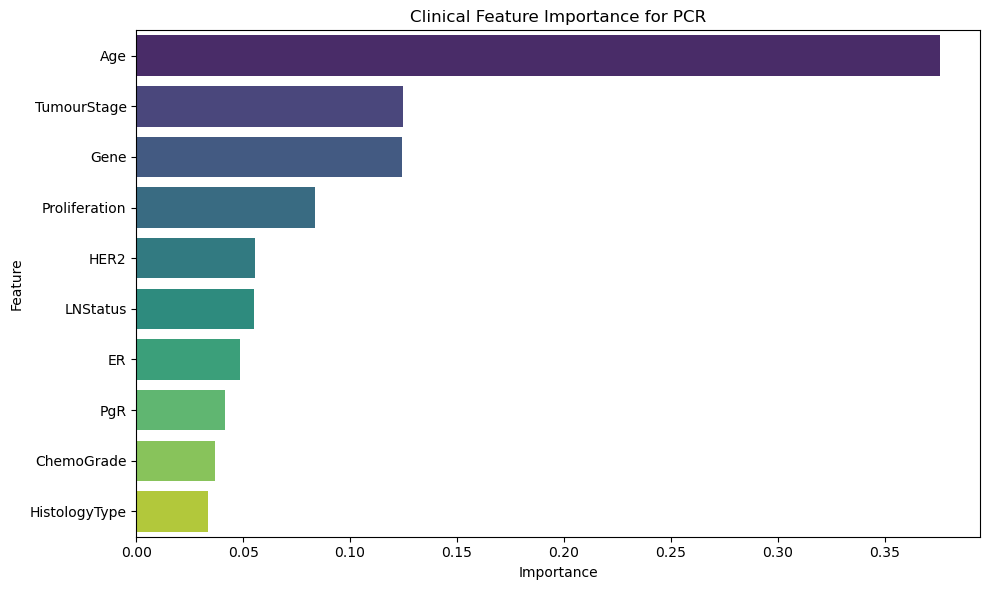

C:\Users\sachi\AppData\Local\Temp\ipykernel_24392\4150406800.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


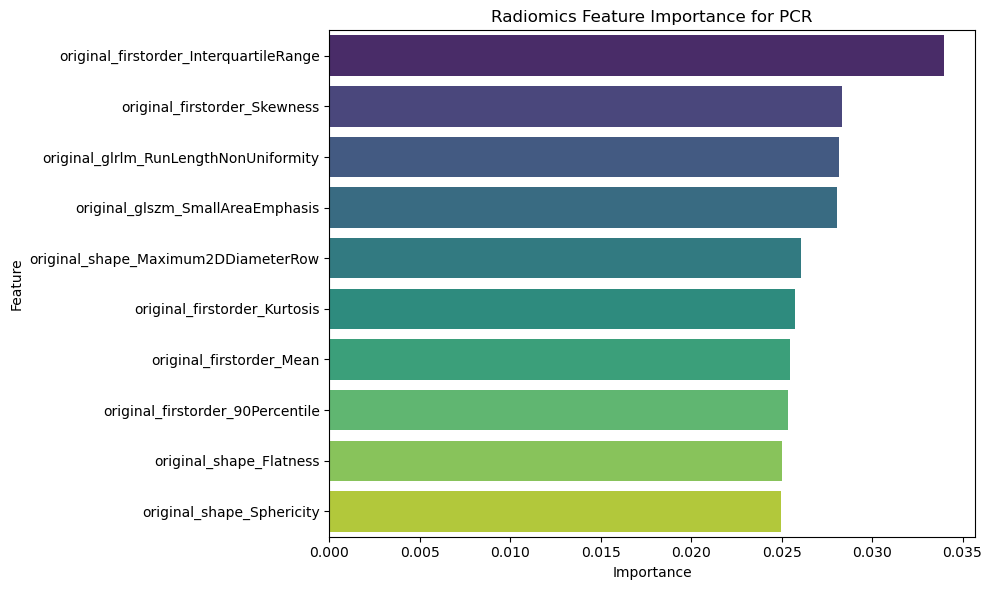

C:\Users\sachi\AppData\Local\Temp\ipykernel_24392\4150406800.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


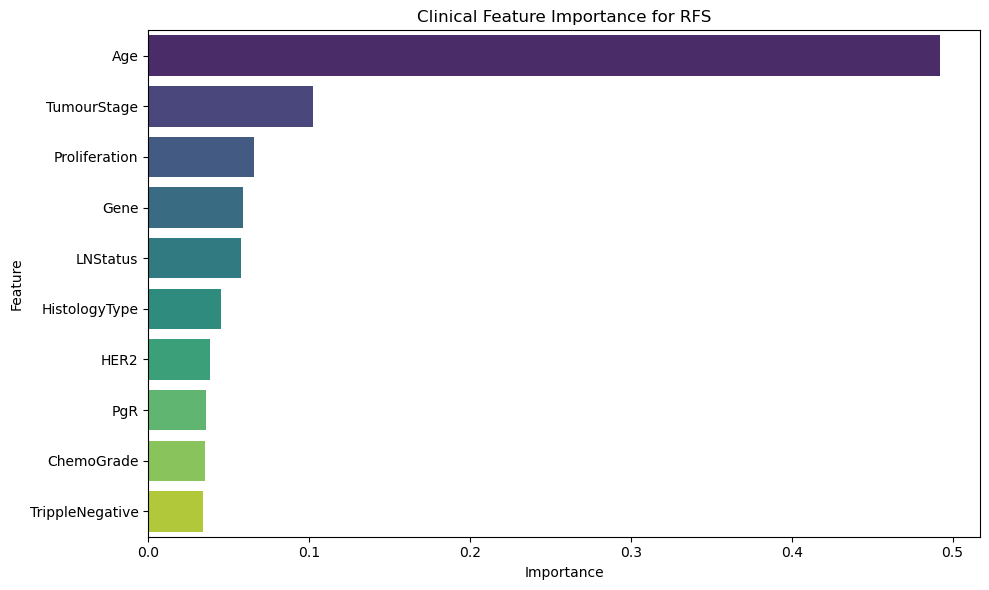

C:\Users\sachi\AppData\Local\Temp\ipykernel_24392\4150406800.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


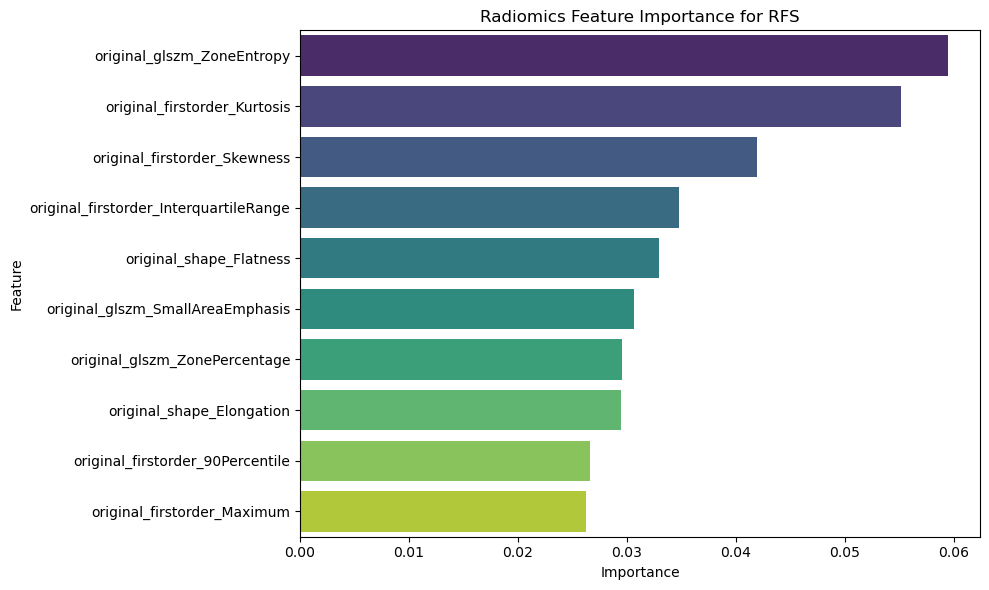

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance_df, title="Feature Importance", top_n=10):
    """
    Plot the feature importance as a bar chart.
    
    Args:
        importance_df: DataFrame with columns ["Feature", "Importance"].
        title: Title for the plot.
        top_n: Number of top features to display.
    """
    # Sort features by importance
    importance_df = importance_df.sort_values(by="Importance", ascending=False).head(top_n)
    
    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Visualize clinical feature importance for PCR
plot_feature_importance(clinical_importance_pcr, title="Clinical Feature Importance for PCR", top_n=10)

# Visualize radiomics feature importance for PCR
plot_feature_importance(radiomics_importance_pcr, title="Radiomics Feature Importance for PCR", top_n=10)

# Visualize clinical feature importance for RFS
plot_feature_importance(clinical_importance_rfs, title="Clinical Feature Importance for RFS", top_n=10)

# Visualize radiomics feature importance for RFS
plot_feature_importance(radiomics_importance_rfs, title="Radiomics Feature Importance for RFS", top_n=10)


In [9]:
# Check for class imbalance in the "pCR (outcome)" column
class_distribution_pcr = target_pcr.value_counts(normalize=True) * 100

# Display the class distribution
class_distribution_pcr_summary = {
    "Class 0 (Non-PCR)": class_distribution_pcr.get(0, 0),
    "Class 1 (PCR)": class_distribution_pcr.get(1, 0)
}

class_distribution_pcr_summary


{'Class 0 (Non-PCR)': 78.73417721518987, 'Class 1 (PCR)': 21.265822784810126}

In [25]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Step 1: Split the data
# Clinical features for PCR and RFS
X_clinical = data_cleaned[clinical_features]
target_pcr = data_cleaned["pCR (outcome)"].astype(int)
target_rfs = data_cleaned["RelapseFreeSurvival (outcome)"]

# Radiomics features for PCR and RFS
X_radiomics = data_cleaned[selected_radiomics_features]

# Split data into training and testing sets for PCR
X_train_clinical_pcr, X_test_clinical_pcr, y_train_pcr, y_test_pcr = train_test_split(
    X_clinical, target_pcr, test_size=0.2,
    ##, random_state=42
)

X_train_radiomics_pcr, X_test_radiomics_pcr, _, _ = train_test_split(
    X_radiomics, target_pcr, test_size=0.2 
    ##, random_state=42
)

# Split data into training and testing sets for RFS
X_train_clinical_rfs, X_test_clinical_rfs, y_train_rfs, y_test_rfs = train_test_split(
    X_clinical, target_rfs, test_size=0.2 
    ##, random_state=42
)
X_train_radiomics_rfs, X_test_radiomics_rfs, _, _ = train_test_split(
    X_radiomics, target_rfs, test_size=0.2 
    ##, random_state=42
)

# Step 2: Train Models
# Random Forest Classifier for PCR
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_clinical_pcr, y_train_pcr)

# Random Forest Regressor for RFS
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train_clinical_rfs, y_train_rfs)

# Step 3: Evaluate Models
# PCR (Classification)
y_pred_pcr = rf_classifier.predict(X_test_clinical_pcr)
y_pred_proba_pcr = rf_classifier.predict_proba(X_test_clinical_pcr)[:, 1]
classification_metrics = classification_report(y_test_pcr, y_pred_pcr, output_dict=True)
roc_auc_pcr = roc_auc_score(y_test_pcr, y_pred_proba_pcr)

# RFS (Regression)
y_pred_rfs = rf_regressor.predict(X_test_clinical_rfs)
mse_rfs = mean_squared_error(y_test_rfs, y_pred_rfs)
mae_rfs = mean_absolute_error(y_test_rfs, y_pred_rfs)
r2_rfs = r2_score(y_test_rfs, y_pred_rfs)

# Display results
results = {
    "PCR Classification Metrics": classification_metrics,
    "PCR ROC-AUC": roc_auc_pcr,
    "RFS Regression Metrics": {
        "MSE": mse_rfs,
        "MAE": mae_rfs,
        "R²": r2_rfs
    }
}

results


{'PCR Classification Metrics': {'0': {'precision': 0.8695652173913043,
   'recall': 0.9090909090909091,
   'f1-score': 0.8888888888888888,
   'support': 66.0},
  '1': {'precision': 0.4,
   'recall': 0.3076923076923077,
   'f1-score': 0.34782608695652173,
   'support': 13.0},
  'accuracy': 0.810126582278481,
  'macro avg': {'precision': 0.6347826086956522,
   'recall': 0.6083916083916083,
   'f1-score': 0.6183574879227053,
   'support': 79.0},
  'weighted avg': {'precision': 0.792294991744634,
   'recall': 0.810126582278481,
   'f1-score': 0.799853237937993,
   'support': 79.0}},
 'PCR ROC-AUC': 0.8327505827505828,
 'RFS Regression Metrics': {'MSE': 943.494746407701,
  'MAE': 24.578202531613922,
  'R²': -0.2878944141837796}}

<Figure size 800x600 with 0 Axes>

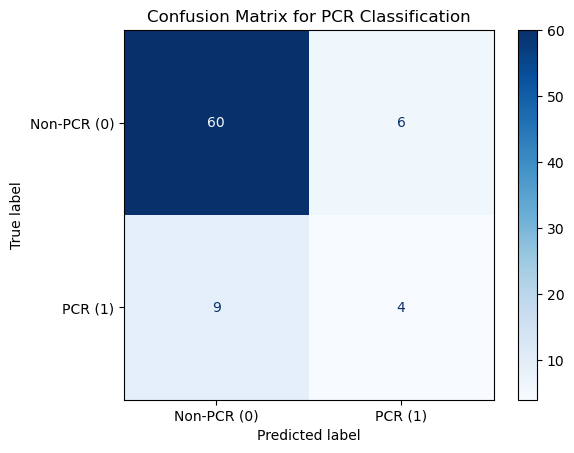

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89        66
           1       0.40      0.31      0.35        13

    accuracy                           0.81        79
   macro avg       0.63      0.61      0.62        79
weighted avg       0.79      0.81      0.80        79



In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix for PCR classification
conf_matrix = confusion_matrix(y_test_pcr, y_pred_pcr, labels=[0, 1])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-PCR (0)", "PCR (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix for PCR Classification")
plt.show()

# Classification report visualization
class_report = classification_report(y_test_pcr, y_pred_pcr)
print("Classification Report:\n", class_report)


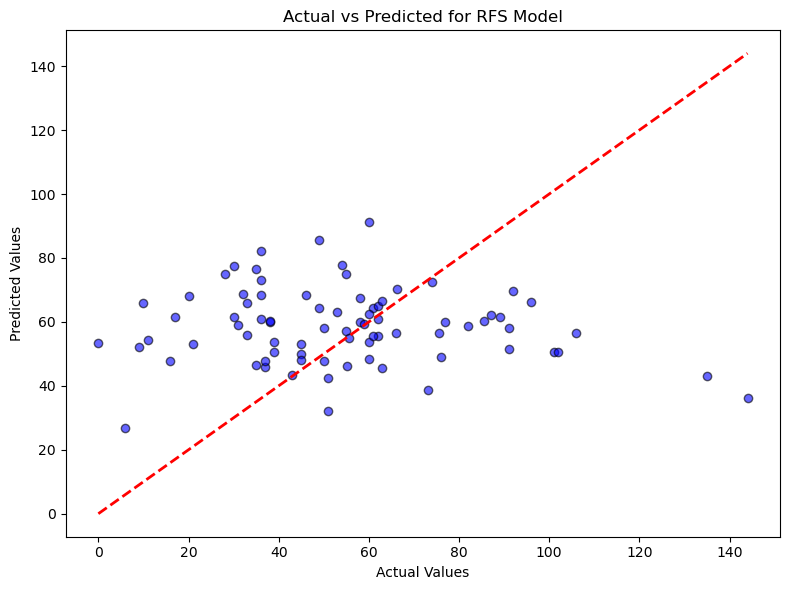

In [12]:
# Plot actual vs predicted values for the RFS regression model
def plot_actual_vs_predicted(y_actual, y_predicted, title="Actual vs Predicted"):
    """
    Plot the actual vs. predicted values for a regression model.
    Args:
        y_actual: Actual target values.
        y_predicted: Predicted target values.
        title: Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.6, color='blue', edgecolor='k')
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.title(title)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.tight_layout()
    plt.show()

# Call the function to visualize RFS regression performance
plot_actual_vs_predicted(y_test_rfs, y_pred_rfs, title="Actual vs Predicted for RFS Model")


2.1.3


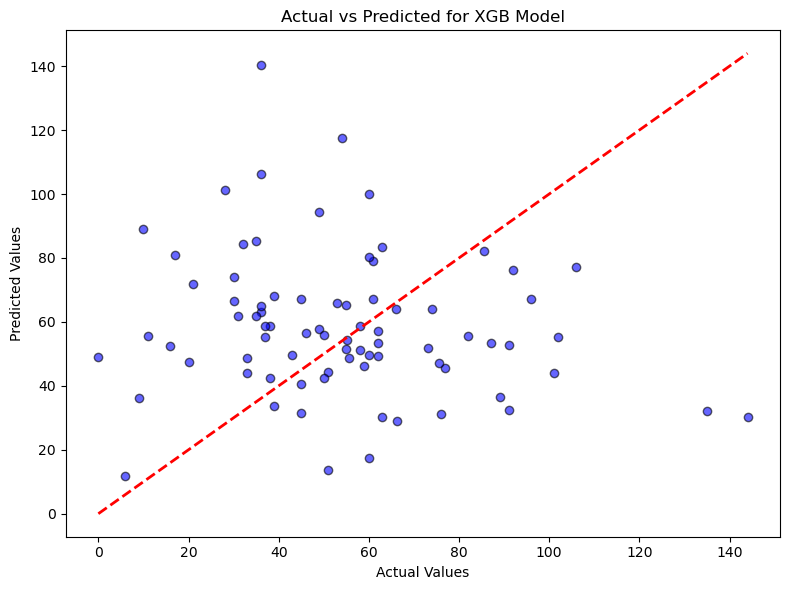

{'RFS Regression Metrics': {'MSE': 971.0609364947247,
  'MAE': 23.93593248939747,
  'R²': -0.30007468640866986}}

In [13]:
import xgboost as xgb
print(xgb.__version__)  # Should print the installed version
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_clinical_rfs, y_train_rfs)
y_pred_rfs_xgb = xgb_model.predict(X_test_clinical_rfs)


# Plot actual vs predicted values for the XGBoost regression model
def plot_actual_vs_predicted(y_actual, y_predicted, title="Actual vs Predicted"):
    """
    Plot the actual vs. predicted values for a regression model.
    Args:
        y_actual: Actual target values.
        y_predicted: Predicted target values.
        title: Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.6, color='blue', edgecolor='k')
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.title(title)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.tight_layout()
    plt.show()

# Call the function to visualize RFS regression performance
plot_actual_vs_predicted(y_test_rfs, y_pred_rfs_xgb, title="Actual vs Predicted for XGB Model")

# RFS (Regression)
y_pred_rfs = rf_regressor.predict(X_test_clinical_rfs)
mse_rfs = mean_squared_error(y_test_rfs, y_pred_rfs)
mae_rfs = mean_absolute_error(y_test_rfs, y_pred_rfs)
r2_rfs = r2_score(y_test_rfs, y_pred_rfs)

# Display results
results = {
    "RFS Regression Metrics": {
        "MSE": mse_rfs,
        "MAE": mae_rfs,
        "R²": r2_rfs
    }
}

results


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 11
[LightGBM] [Info] Start training from score 56.081487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

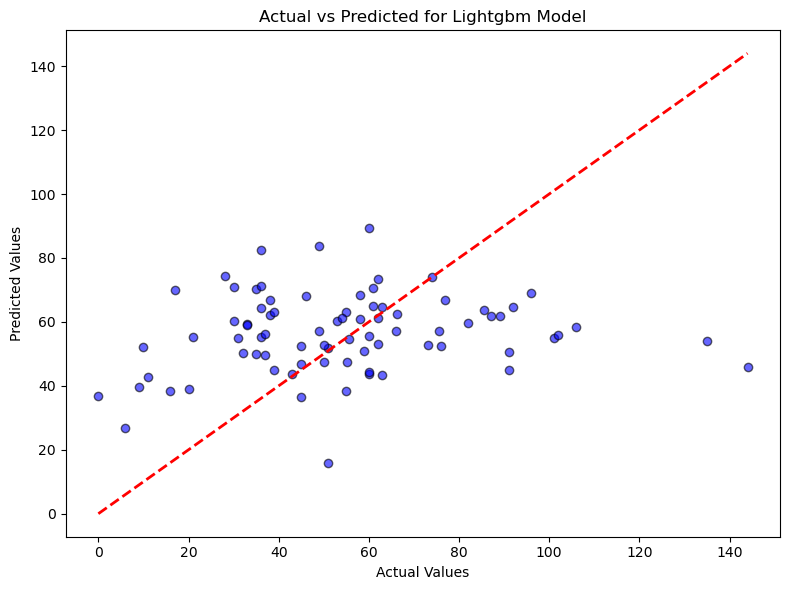

{'RFS Regression Metrics': {'MSE': 971.0609364947247,
  'MAE': 23.93593248939747,
  'R²': -0.30007468640866986}}

In [14]:
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor(random_state=42)
lgb_model.fit(X_train_clinical_rfs, y_train_rfs)
y_pred_rfs_lgb = lgb_model.predict(X_test_clinical_rfs)

# Plot actual vs predicted values for the LGBM regression model
def plot_actual_vs_predicted(y_actual, y_predicted, title="Actual vs Predicted"):
    """
    Plot the actual vs. predicted values for a regression model.
    Args:
        y_actual: Actual target values.
        y_predicted: Predicted target values.
        title: Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.6, color='blue', edgecolor='k')
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.title(title)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.tight_layout()
    plt.show()

# Call the function to visualize RFS regression performance
plot_actual_vs_predicted(y_test_rfs, y_pred_rfs_lgb, title="Actual vs Predicted for Lightgbm Model")

# RFS (Regression)
y_pred_rfs = rf_regressor.predict(X_test_clinical_rfs)
mse_rfs = mean_squared_error(y_test_rfs, y_pred_rfs)
mae_rfs = mean_absolute_error(y_test_rfs, y_pred_rfs)
r2_rfs = r2_score(y_test_rfs, y_pred_rfs)

# Display results
results = {
    "RFS Regression Metrics": {
        "MSE": mse_rfs,
        "MAE": mae_rfs,
        "R²": r2_rfs
    }
}

results


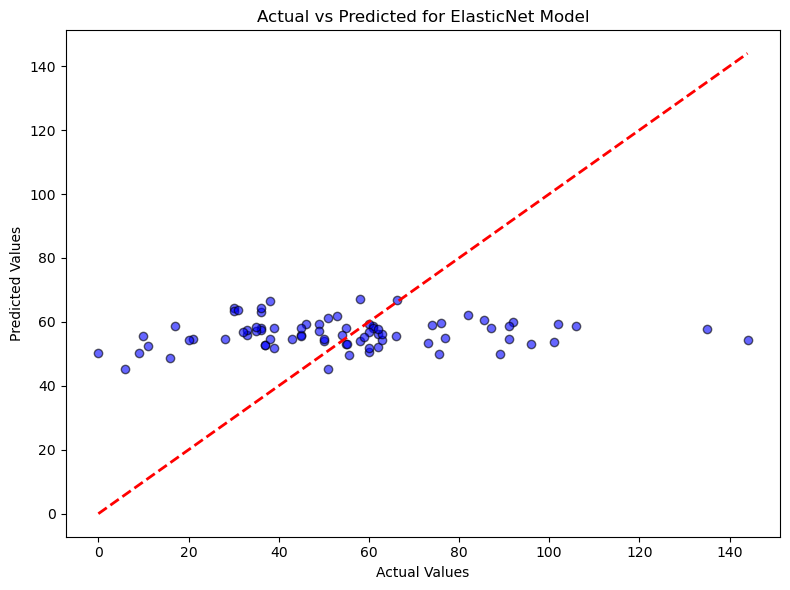

{'RFS Regression Metrics': {'MSE': 971.0609364947247,
  'MAE': 23.93593248939747,
  'R²': -0.30007468640866986}}

In [15]:
from sklearn.linear_model import ElasticNet

elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_model.fit(X_train_clinical_rfs, y_train_rfs)
y_pred_rfs_en = elastic_model.predict(X_test_clinical_rfs)

# Plot actual vs predicted values for the ElasticNet model
def plot_actual_vs_predicted(y_actual, y_predicted, title="Actual vs Predicted"):
    """
    Plot the actual vs. predicted values for a regression model.
    Args:
        y_actual: Actual target values.
        y_predicted: Predicted target values.
        title: Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.6, color='blue', edgecolor='k')
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.title(title)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.tight_layout()
    plt.show()

# Call the function to visualize RFS regression performance
plot_actual_vs_predicted(y_test_rfs, y_pred_rfs_en, title="Actual vs Predicted for ElasticNet Model")

# RFS (Regression)
y_pred_rfs = rf_regressor.predict(X_test_clinical_rfs)
mse_rfs = mean_squared_error(y_test_rfs, y_pred_rfs)
mae_rfs = mean_absolute_error(y_test_rfs, y_pred_rfs)
r2_rfs = r2_score(y_test_rfs, y_pred_rfs)

# Display results
results = {
    "RFS Regression Metrics": {
        "MSE": mse_rfs,
        "MAE": mae_rfs,
        "R²": r2_rfs
    }
}

results


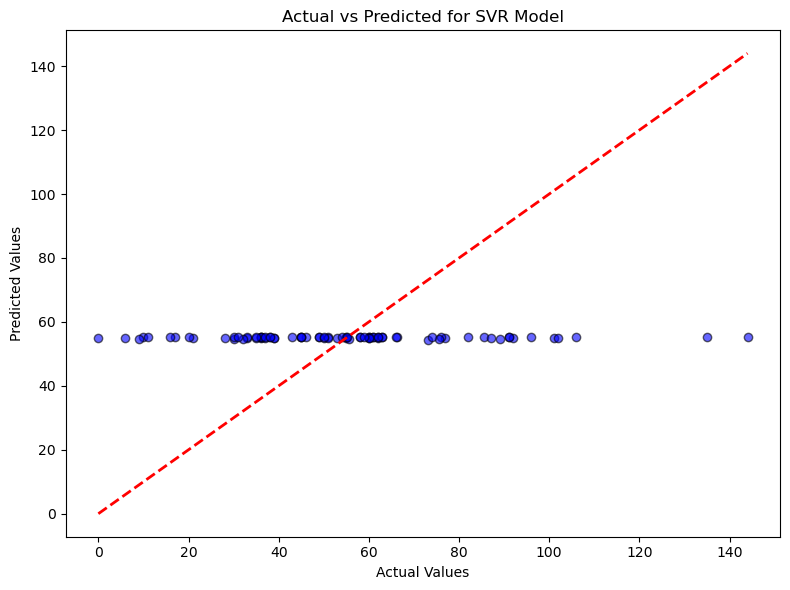

{'RFS Regression Metrics': {'MSE': 971.0609364947247,
  'MAE': 23.93593248939747,
  'R²': -0.30007468640866986}}

In [16]:
from sklearn.svm import SVR

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svr_model.fit(X_train_clinical_rfs, y_train_rfs)
y_pred_rfs_svr = svr_model.predict(X_test_clinical_rfs)

# Plot actual vs predicted values for the SVR model
def plot_actual_vs_predicted(y_actual, y_predicted, title="Actual vs Predicted"):
    """
    Plot the actual vs. predicted values for a regression model.
    Args:
        y_actual: Actual target values.
        y_predicted: Predicted target values.
        title: Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.6, color='blue', edgecolor='k')
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.title(title)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.tight_layout()
    plt.show()

# Call the function to visualize RFS regression performance
plot_actual_vs_predicted(y_test_rfs, y_pred_rfs_svr, title="Actual vs Predicted for SVR Model")

# RFS (Regression)
y_pred_rfs = rf_regressor.predict(X_test_clinical_rfs)
mse_rfs = mean_squared_error(y_test_rfs, y_pred_rfs)
mae_rfs = mean_absolute_error(y_test_rfs, y_pred_rfs)
r2_rfs = r2_score(y_test_rfs, y_pred_rfs)

# Display results
results = {
    "RFS Regression Metrics": {
        "MSE": mse_rfs,
        "MAE": mae_rfs,
        "R²": r2_rfs
    }
}

results

In [17]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


Epoch 1/50


C:\Users\sachi\AnacondaV2\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4014.3203 - mae: 57.3688
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2868.5403 - mae: 46.7292 
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1893.2321 - mae: 36.3765 
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1498.0374 - mae: 31.6566 
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 990.7099 - mae: 24.8140 
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 871.1593 - mae: 22.5883 
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 937.4082 - mae: 23.6614  
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 839.9006 - mae: 22.7258 
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 843.9521 - mae: 22.3986 
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 961.9594 - mae: 23.8602  
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 788.1973 - mae: 21.5329 
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 808.9800 - mae: 21.9348 
Epoch 1

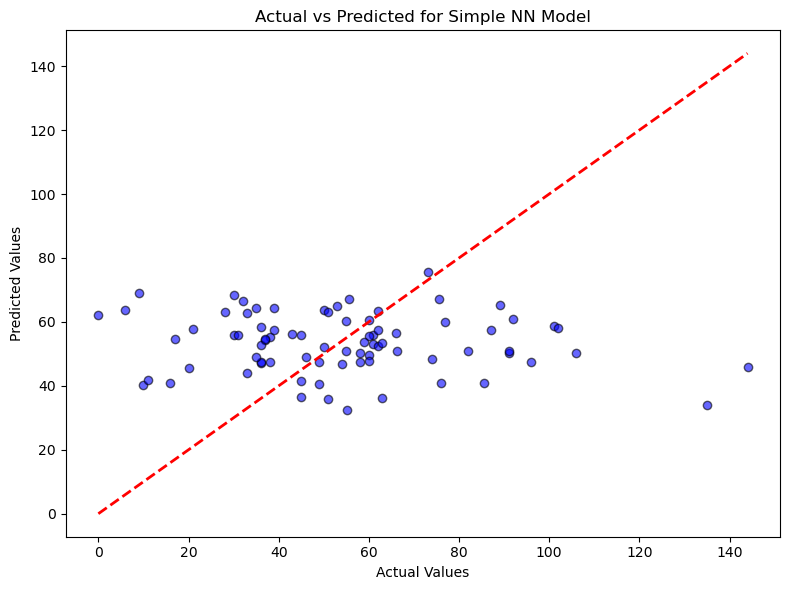

{'RFS Regression Metrics': {'MSE': 971.0609364947247,
  'MAE': 23.93593248939747,
  'R²': -0.30007468640866986}}

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

nn_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_clinical_rfs.shape[1]),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
nn_model.fit(X_train_clinical_rfs, y_train_rfs, epochs=50, batch_size=32, verbose=1)
y_pred_rfs_nn = nn_model.predict(X_test_clinical_rfs)


# Plot actual vs predicted values for the SNN model
def plot_actual_vs_predicted(y_actual, y_predicted, title="Actual vs Predicted"):
    """
    Plot the actual vs. predicted values for a regression model.
    Args:
        y_actual: Actual target values.
        y_predicted: Predicted target values.
        title: Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.6, color='blue', edgecolor='k')
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.title(title)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.tight_layout()
    plt.show()

# Call the function to visualize RFS regression performance
plot_actual_vs_predicted(y_test_rfs, y_pred_rfs_nn, title="Actual vs Predicted for Simple NN Model")

# RFS (Regression)
y_pred_rfs = rf_regressor.predict(X_test_clinical_rfs)
mse_rfs = mean_squared_error(y_test_rfs, y_pred_rfs)
mae_rfs = mean_absolute_error(y_test_rfs, y_pred_rfs)
r2_rfs = r2_score(y_test_rfs, y_pred_rfs)

# Display results
results = {
    "RFS Regression Metrics": {
        "MSE": mse_rfs,
        "MAE": mae_rfs,
        "R²": r2_rfs
    }
}

results

In [19]:
pip install --user h2o

Note: you may need to restart the kernel to use updated packages.


In [21]:
import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Initialize H2O
h2o.init()

# Step 2: Convert data to H2OFrame
h2o_train = h2o.H2OFrame(pd.concat([X_train_clinical_rfs, y_train_rfs], axis=1))
h2o_test = h2o.H2OFrame(pd.concat([X_test_clinical_rfs, y_test_rfs], axis=1))

# Step 3: Train AutoML
aml = H2OAutoML(max_models=20, seed=42)
aml.train(y="RFS", training_frame=h2o_train)

# Step 4: Retrieve the best model
best_model = aml.leader
print("Best Model:", best_model)

# Step 5: Make predictions
predictions = best_model.predict(h2o_test)

# Step 6: Convert predictions to pandas DataFrame
predicted_values = h2o.as_list(predictions, use_pandas=True)
actual_values = y_test_rfs.reset_index(drop=True)

# Step 7: Evaluate the predictions
mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.261-b12, mixed mode)
  Starting server from C:\Users\sachi\AppData\Roaming\Python\Python312\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\sachi\AppData\Local\Temp\tmpadr0cshy
  JVM stdout: C:\Users\sachi\AppData\Local\Temp\tmpadr0cshy\h2o_sachi_started_from_python.out
  JVM stderr: C:\Users\sachi\AppData\Local\Temp\tmpadr0cshy\h2o_sachi_started_from_python.err


C:\Users\sachi\AppData\Roaming\Python\Python312\site-packages\h2o\backend\server.py:395: UserWarning:   You have a 32-bit version of Java. H2O works best with 64-bit Java.
  Please download the latest 64-bit Java SE JDK from Oracle.

  warn("  You have a 32-bit version of Java. H2O works best with 64-bit Java.\n"


  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_sachi_86ej7z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,247.5 Mb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


H2OValueError: Column RFS does not exist in the training frame